# 0.0 Import libraries

In [1]:
# Data wrangling
import numpy      as np

import pandas     as pd

# SQL in Python
# import psycopg2   as pg

# Data visualization and EDA
import seaborn        as sns
import scikitplot     as skplt
import plotly.express as px
import matplotlib

from tabulate   import tabulate
from matplotlib import pyplot          as plt

# Feature selection
import boruta     as bt

# Data preprocessing 
from sklearn    import preprocessing   as pp
from sklearn    import model_selection as ms

import pickle

# Models
import xgboost as xgb
import random

from sklearn           import linear_model    as lm
from sklearn           import ensemble        as en
from sklearn           import neighbors       as nh
       
from lightgbm          import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Cross validation
from sklearn.model_selection import RepeatedStratifiedKFold

## 0.1. Helper functions

In [37]:
# Set up jupyter notebook cells settings

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

######################################
#Function to plot gain and lift curve#
######################################

def gain_lift_curve(yhat, y_val, plot = True, size = (24,8), axvline = 'None'):
    '''
    plot gain and lift curves
    returns the graphs and table used to plot the data
    '''

    # Create table proba with the propensity score for each class (0 and 1)
    table_proba = pd.DataFrame(yhat)

    # Add the 'target' column to it
    table_proba['target'] = y_val.values.ravel()

    # add the 'correct' column to evaluate whther the prediction was correct
    x = lambda x: 'yes' if x[0] > x[1] and x['target'] == 0 else 'yes' if x[1] > x[0] and x['target'] == 1 else 'yes' if x[0] == x[1] else 'no'
    table_proba['correct'] = table_proba.apply(x, axis=1)

    # Order propensity score for the class 1
    table_proba.sort_values(1, ascending = False, inplace = True)

    # Create cumulative propensity score
    ## Calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('target').count().loc[1,1]

    # Apply a score for every row in which the target equals 1
    x = lambda x: 1/qty_class_1 if x['target'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create percentage cumulative of the base
    table_proba['perc_base'] = table_proba.apply(lambda x: 1/len(table_proba), axis = 1)
    table_proba['cum_perc_base'] = np.cumsum(table_proba['perc_base'])
    table_proba.drop('perc_base', axis = 1, inplace = True)

    # Create the 'lift' column
    table_proba['lift'] = table_proba['cumulative_propensity_score']/ table_proba['cum_perc_base']

    if plot:
        fig, axes = plt.subplots(1,2,figsize=size)

        # space the figures
        fig.tight_layout(pad=5)

        # gain curve
        sns.lineplot(ax = axes[0], x = table_proba['cum_perc_base'], y = table_proba['cumulative_propensity_score'], label = 'Cumulative (model)', linewidth = 2.5);
        sns.lineplot(ax = axes[0], x = table_proba['cum_perc_base'], y = table_proba['cum_perc_base'], label = 'Baseline', linewidth = 2.5, color = 'black')
        axes[0].lines[1].set_linestyle('--')
        axes[0].legend()
        axes[0].set_title('Cumulative Gains Curve')
        axes[0].set_xlabel('Sample Percentage')
        axes[0].set_ylabel('Gain')

        if axvline != 'None':
            axes[0].axvline(float(axvline), 0,1, color = 'red', ls = '--', lw = 2)

        # Lift curve
        ## Filtering the data at the beginning due to large variation(small sample)
        table_proba_filtered = table_proba.query('cum_perc_base >= 0.1')

        sns.lineplot(ax = axes[1], x = table_proba_filtered['cum_perc_base'], y = table_proba_filtered['lift'], label = 'Model', linewidth = 2.5);
        sns.lineplot(ax = axes[1], x = table_proba_filtered['cum_perc_base'], y = np.ones(len(table_proba_filtered)), label = 'Baseline', linewidth = 2.5, color = 'black')
        axes[1].lines[1].set_linestyle('--')
        axes[1].legend()
        axes[1].set_title('Lift Curve')
        axes[1].set_xlabel('Sample Percentage')
        axes[1].set_ylabel('Lift')

        if axvline != 'None':
            axes[1].axvline(float(axvline), 0,1, color = 'red', ls = '--', lw = 2)

        plt.show()

    return (table_proba)


##############################################
#Function to output precision and recall at k#
##############################################
def precision_recall_at_k(table, k = 2000):
    '''
    Receives the table from gain lift function and outputs:
    1. A tuple containing precision and recall at k;
    2. a new table with recall and precision metrics.
    '''
    table.reset_index(drop = True, inplace = True)
    table['ranking'] = table.index + 1 #this list is required since the index starts in 0
    table['precision_at_k'] = table['target'].cumsum() / table['ranking']
    table['recall_at_k'] = table['target'].cumsum() / table['target'].sum()
    
    return ((table.loc[k-1, 'precision_at_k'], table.loc[k-1, 'recall_at_k']), table)


##################################
#Function for cross - validation #
##################################
# Cross validation
def runCrossValidation  ( model, x_train, x_val, y_train, y_val, n_splits, n_repeats, top_k = 20000, verbose = False ):

    if verbose:
        # the lenght_msg is to print only once a specific message
        lenght_msg = True
        i = 1

    # use seed for repeatability
    np.random.seed(10)

    # concatenate the train and validation datasets
    x=pd.concat([x_train, x_val])
    y=pd.concat([y_train,y_val])

    # Cross validation strategy
    # "n_splits" - number of folds (k)
    # "n_repeats" - number of times the cross validator repeats

    n_splits = 5
    n_repeats = 5


    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)

    precision_at_k = []
    recall_at_k = []

    for train_index, prim_val_index in cv.split(x,y):
        x_training, x_prim_val = x.iloc[train_index], x.iloc[prim_val_index]
        y_training, y_prim_val = y.iloc[train_index], y.iloc[prim_val_index]

        if ( verbose == True ) and (lenght_msg == True ):
            print(f'training_lenght:{x_training.shape[0]}\nvalidation_lenght:{x_prim_val.shape[0]}\n\n')
            lenght_msg = False

        if verbose:
            print(f'Iteration number{i}')
            i+=1

        # Fit prediction proba
        model.fit(x_training,y_training.values.ravel())
        yhat_proba = model.predict_proba( x_prim_val)

        # Get results
        table = gain_lift_curve(yhat_proba, y_prim_val, plot = False )
        metrics, new_table = precision_recall_at_k( table, top_k )

        if verbose:
            print(metrics)
            print( '' )

        # save the metrics value to the list
        precision_at_k.append(metrics[0])
        recall_at_k.append(metrics[1])

    df_results = pd.DataFrame([[np.mean(precision_at_k), np.std(precision_at_k)],[np.mean(recall_at_k), np.std(recall_at_k)]], columns = ['mean','std'])

    df_results.index = ['precision_at_k','recall_at_k']

    return ( df_results )


##############################################
#Compilation of precision and recall metrics #
##############################################

def precision_recall_compiled(list_of_dfs, base):
    dict_precision = {'Precision_at':['10%','20%','30%','40%']}
    dict_recall = {'Recall_at': ['10%','20%','30%','40%']}
    for model in list_of_dfs:
        metrics10, _ = precision_recall_at_k(eval (model), (base.shape[0]*10)//100)
        metrics20, _ = precision_recall_at_k(eval (model), (base.shape[0]*20)//100)
        metrics30, _ = precision_recall_at_k(eval (model), (base.shape[0]*30)//100)
        metrics40, _ = precision_recall_at_k(eval (model), (base.shape[0]*40)//100)
    
        dict_precision[model] = [round(metrics10[0],4 ),
                                round(metrics20[0],4 ),
                                round(metrics30[0],4 ),
                                round(metrics40[0],4 )]
        
        dict_recall[model] = [round(metrics10[1],4 ),
                             round(metrics20[1],4 ),
                             round(metrics30[1],4 ),
                             round(metrics40[1],4 )]
    
    df_precision = pd.DataFrame(dict_precision)
    df_recall = pd.DataFrame(dict_recall)

    df_precision.columns = ['Precision at',
                            'k-Nearest Neighbors',
                            'Logistic Regression',
                            'Random Forest',
                            'Balanced Random Forest',
                            'Gradient Boost',
                            'XGBoost',
                            'LGBM']

    df_recall.columns = ['Recall at',
                        'k-Nearest Neighbors',
                        'Logistic Regression',
                        'Random Forest',
                        'Balanced Random Forest',
                        'Gradient Boost',
                        'XGBoost',
                        'LGBM']

    return df_precision, df_recall



# 0.2. Load data

In [22]:
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw = df_raw.drop(['id.1', 'id.2'], axis=1)
df_raw.shape
# print(df_raw.shape)

(381109, 12)

Here is a short description of each variable in the dataset:  


Table 1. Description of each variable in the dataset.
| Variable | Definition |
|:---:|:---|
| id | Unique ID for the customer |
| Gender | Gender of the customer |
| Age | Age of the customer |
| Driving_License | 0 : Customer does not have DL, 1 : Customer already has DL |
| Region_Code | Unique code for the region of the customer |
| Previously_Insured | 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance |
| Vehicle_Age | Age of the Vehicle |
| Vehicle_Damage | 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past. |
| Annual_Premium | The amount customer needs to pay as premium in the year |
| Policy_Sales_Channel | Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. |
| Vintage | Number of Days, Customer has been associated with the company |
| Response | 1 : Customer is interested, 0 : Customer is not interested |

# 0.3. Split Data

**Split data: base and test**

In [23]:
X = df_raw.drop('response', axis = 1)
y = df_raw['response'].copy()

X_base,X_test, y_base, y_test = ms.train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True)

df_test = pd.concat([X_test, y_test], axis = 1)

print("Dimension of split data")
print(f'X_base:{X_base.shape}\ny_base:{y_base.shape}\nX_test:{X_test.shape}\ny_test:{y_test.shape}\n')

# Clean the environment for system performance
del df_raw, X, y, X_test


Dimension of split data
X_base:(323942, 11)
y_base:(323942,)
X_test:(57167, 11)
y_test:(57167,)



**Split base in train and validation sets**

In [24]:
base = pd.concat([X_base, y_base], axis = 1)

X = base.drop('response', axis = 1)
y = base['response'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split(X,y, test_size = 0.15,stratify=y, shuffle=True)

print("Dimension of split base into train and validation sets")
print(f'X_train:{X_train.shape}\ny_train:{y_train.shape}\nX_val:{X_val.shape}\ny_val:{y_val.shape}\n')

df1_train = pd.concat([X_train, y_train], axis = 1)
df1_val = pd.concat([X_val, y_val], axis = 1)

# Clean environment for performance
del base, X, y, X_base, y_base, X_train, X_val, y_val

Dimension of split base into train and validation sets
X_train:(275350, 11)
y_train:(275350,)
X_val:(48592, 11)
y_val:(48592,)



# 1.0 Data description

In [6]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275350 entries, 161443 to 297923
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    275350 non-null  int64  
 1   gender                275350 non-null  object 
 2   age                   275350 non-null  int64  
 3   region_code           275350 non-null  float64
 4   policy_sales_channel  275350 non-null  float64
 5   driving_license       275350 non-null  int64  
 6   vehicle_age           275350 non-null  object 
 7   vehicle_damage        275350 non-null  object 
 8   previously_insured    275350 non-null  int64  
 9   annual_premium        275350 non-null  float64
 10  vintage               275350 non-null  int64  
 11  response              275350 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 27.3+ MB


In [7]:
print(f"Variable 'response' has {df1_train.loc[df1_train['response'] == 0,'response'].count() / len(df1_train)*100:.1f}% of '0'")
print(f"and {df1_train.loc[df1_train['response'] == 1,'response'].count() / len(df1_train)*100:.1f}% of 1") 

Variable 'response' has 87.7% of '0'
and 12.3% of 1


## 1.1. Check NA

In [8]:
df1_train.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.2. Descriptive statistics

In [9]:
num_att = df1_train.select_dtypes( include = ['int64','float64'] )
cat_att = df1_train.select_dtypes( exclude = ['int64','float64', 'datetime64[ns]'] )

In [10]:
%%time
# Central tendency of data
ct1 = pd.DataFrame( num_att.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_att.apply( np.median ) ).T

# Data dispersion
d1 = pd.DataFrame( num_att.apply( np.std )).T
d2 = pd.DataFrame( num_att.apply( min )).T
d3 = pd.DataFrame( num_att.apply( max )).T
d4 = pd.DataFrame( num_att.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_att.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_att.apply( lambda x: x.kurtosis() )).T

# Concatenate descriptive statistics
d_stats = pd.concat([ct1, d1, ct2, d2, d3, d4, d5, d6] ).T.reset_index()
d_stats.columns = ['attributes', 'mean','SD', 'median', 'min', 'max', 'range', 'skew', 'kurtosis']
print(d_stats)

# Cleaning the environment for performance
del cat_att, num_att, ct1, ct2, d_stats, d1,d2,d3,d4,d5,d6

             attributes           mean             SD    median     min  \
0                    id  190516.773732  109926.069923  190477.0     1.0   
1                   age      38.823733      15.516638      36.0    20.0   
2           region_code      26.373158      13.233934      28.0     0.0   
3  policy_sales_channel     112.057367      54.207154     136.0     1.0   
4       driving_license       0.997868       0.046123       1.0     0.0   
5    previously_insured       0.459019       0.498318       0.0     0.0   
6        annual_premium   30567.319608   17232.988554   31660.0  2630.0   
7               vintage     154.285978      83.663814     154.0    10.0   
8              response       0.122560       0.327932       0.0     0.0   

        max     range       skew    kurtosis  
0  381108.0  381107.0   0.000131   -1.198814  
1      85.0      65.0   0.673557   -0.564193  
2      52.0      52.0  -0.113665   -0.870483  
3     163.0     162.0  -0.900966   -0.969321  
4       1.0   

# 2.0 Feature Engineering

**Train**

In [25]:
# Vehicle damage number
df1_train['vehicle_damage'] = df1_train['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# Vehicle age
df1_train['vehicle_age'] = df1_train['vehicle_age'].apply(lambda x: 'over_2_years'      if x == '> 2 Years' else
                                                        'between_1_2_years' if x == '1-2 Year'  else 'below_1_year')

**Validation**

In [26]:
# Vehicle damage number
df1_val['vehicle_damage'] = df1_val['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# Vehicle age
df1_val['vehicle_age'] = df1_val['vehicle_age'].apply(lambda x: 'over_2_years'      if x == '> 2 Years' else
                                                        'between_1_2_years' if x == '1-2 Year'  else 'below_1_year')

# 3.0 Data Filtering

# 4.0 Exploratory Data Analysis (EDA)

## 4.1 Univariate Analysis

### 4.1.1 Age

/tmp/ipykernel_49178/3205682965.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.

/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` t

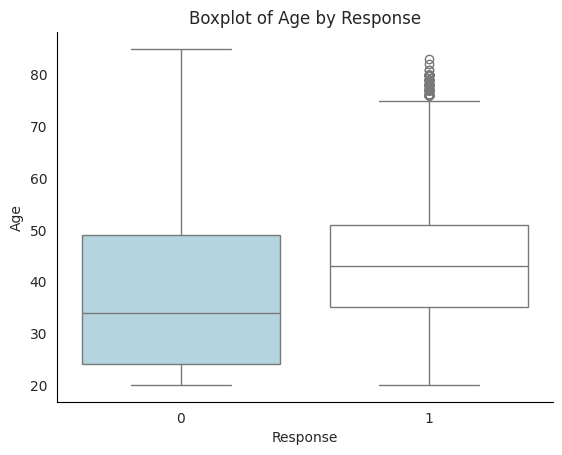

In [47]:
# Set up the color palette
colors = {'0': 'lightblue', '1': 'white'}

# Set the style to remove the grid background
sns.set_style("whitegrid")

# Create the boxplot
sns.boxplot(x='response', y='age', data=df1_train, palette=colors)

# Set labels and title
plt.xlabel('Response')
plt.ylabel('Age')
plt.title('Boxplot of Age by Response')

# Remove the top and right axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove horizontal gridlines
plt.grid(False)

# Paint the y and x axes black
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Show the plot
plt.show()

Figure 1. Boxplot of the responses by client's age.

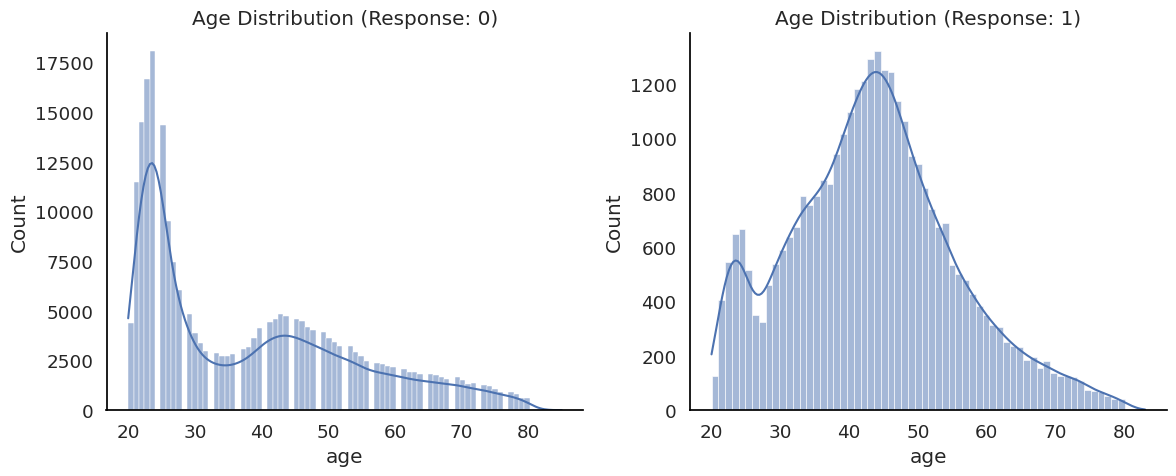

In [179]:
# Set up 1x2 grid for subplots
fig,axes = plt.subplots(1,2,figsize = (12,5))

# Chunk 1 - Histogram for age of those who don't want to buy
age_hist_no = df1_train.loc[df1_train['response'] == 0, 'age']
sns.histplot(age_hist_no, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution (Response: 0)')
axes[0].grid(False)
# Remove the top and right axes
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
# Paint the y and x axes black
axes[0].spines['left'].set_color('black')
axes[0].spines['bottom'].set_color('black')

# Chunk 2 - Histogram for age of those who want to buy
age_hist_yes = df1_train.loc[df1_train['response'] == 1, 'age']
sns.histplot(age_hist_yes, kde=True, ax=axes[1])
axes[1].set_title('Age Distribution (Response: 1)')
axes[1].grid(False)
# Remove the top and right axes
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
# Paint the y and x axes black
axes[1].spines['left'].set_color('black')
axes[1].spines['bottom'].set_color('black')

# Adjust to prevent overlapping
plt.tight_layout()




# Show Plots
plt.show();


Figure 2. Distribution of the responses by age.

### 4.1.2 Annual Premium

In [7]:
df1_train_ftr = df1_train.loc[(df1_train['annual_premium'] > 10000) & (df1_train['annual_premium'] < 100000), :]

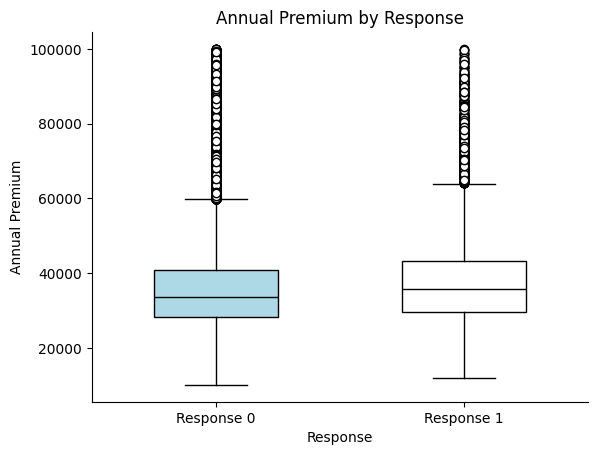

In [11]:
# Extract data for each response category
data_response_0 = df1_train_ftr[df1_train_ftr['response'] == 0]['annual_premium']
data_response_1 = df1_train_ftr[df1_train_ftr['response'] == 1]['annual_premium']

# Create a boxplot using Matplotlib with custom colors and median line
boxplot = plt.boxplot([data_response_0, data_response_1],
                      labels=['Response 0', 'Response 1'],
                      patch_artist=True,  # Enable patch_artist for custom box colors
                      medianprops=dict(color='black'),  # Median line color
                      whiskerprops=dict(color='black'),  # Whisker color
                      capprops=dict(color='black'),  # Caps on whiskers color
                      flierprops=dict(markeredgecolor='black', markerfacecolor='white'),
                      widths = 0.5)  # Outliers color

# Set custom box colors
colors = ['lightblue', 'white']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel('Response')
plt.ylabel('Annual Premium')
plt.title('Annual Premium by Response')

# Remove background grid
plt.grid(False)
# Remove the top and right axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Paint the y and x axes black
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

plt.grid(False)

# Show the plot
plt.show()


Figure 3. Boxplot of the responses by annual premium.

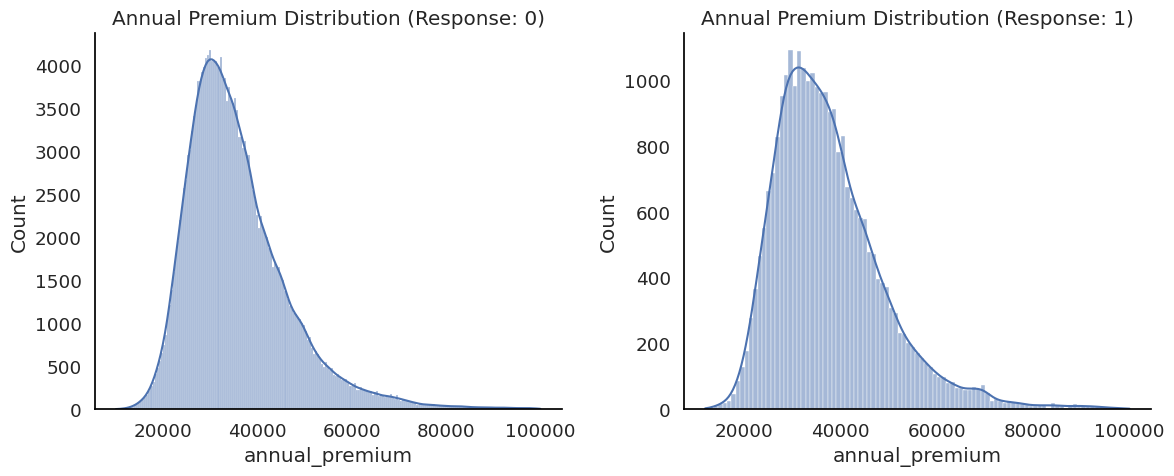

In [182]:
# Set up 1x2 grid for subplots
fig,axes = plt.subplots(1,2,figsize = (12,5))

# Chunk 1 - Histogram for annual_premium of those who don't want to buy
ann_prm_hist_no = df1_train_ftr.loc[df1_train_ftr['response'] == 0, 'annual_premium']
sns.histplot(ann_prm_hist_no, kde=True, ax=axes[0])
axes[0].set_title('Annual Premium Distribution (Response: 0)')
axes[0].grid(False)
# Remove the top and right axes
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
# Paint the y and x axes black
axes[0].spines['left'].set_color('black')
axes[0].spines['bottom'].set_color('black')

# Chunk 2 - Histogram for annual_premium of those who want to buy
ann_prm_hist_yes = df1_train_ftr.loc[df1_train_ftr['response'] == 1, 'annual_premium']
sns.histplot(ann_prm_hist_yes, kde=True, ax=axes[1])
axes[1].set_title('Annual Premium Distribution (Response: 1)')
axes[1].grid(False)
# Remove the top and right axes
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
# Paint the y and x axes black
axes[1].spines['left'].set_color('black')
axes[1].spines['bottom'].set_color('black')

# Adjust to prevent overlapping
plt.tight_layout()

# Show Plots
plt.show();


Figure 4. Distribution of the responses by annual premium.

### 4.1.3. Driving License

In [141]:
df4_aux = df1_train_ftr[['driving_license', 'response']].groupby('response').sum().reset_index()
df4_aux['driving_license_perc'] = round(df4_aux['driving_license'] / df4_aux['driving_license'].sum(),2)*100
df4_aux

,response,driving_license,driving_license_perc
0,0,200067,88.0
1,1,27485,12.0


In [8]:
# Subset dataframe for plotting visualization

df = df1_train_ftr[['gender','response']]

# Calculate the relative rate of the response by gender
df_grouped = df.groupby(['gender','response']).size().reset_index(name='count')

df_grouped['relative_rate'] = np.round(df_grouped.groupby('gender')['count'].transform(lambda x: x/x.sum()),2)

df_grouped['relative_rate_formated'] = (np.round(df_grouped['relative_rate'],4) * 100).astype(str)

# Plot stacked bar chart using plotly express
fig = px.bar(df_grouped, x='gender', y='relative_rate', color='response', barmode='stack', text='relative_rate_formated')
fig.show()

Figure 5. Responses of each gender.

In [143]:
# Clean environment for performance
del age_hist_no, age_hist_yes, boxplot, color, colors, data_response_0, data_response_1, df, df_aux2, df_aux3, df4_aux, df_grouped


### 4.1.4 Region Code

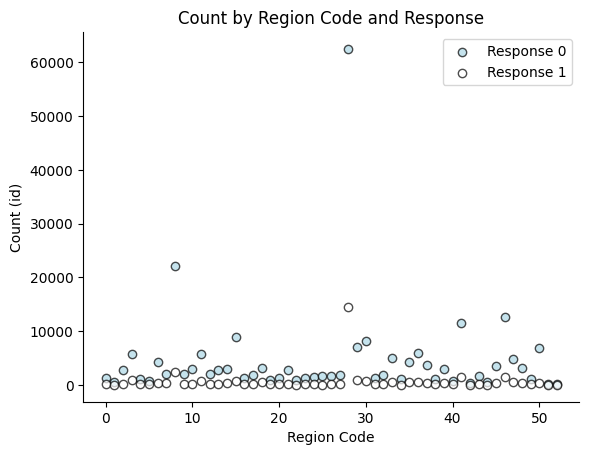

In [34]:
# Data
df_grouped = df1_train[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

# Extracting data for each response
response_0 = df_grouped[df_grouped['response'] == 0]
response_1 = df_grouped[df_grouped['response'] == 1]

# Plotting scatter plot
plt.scatter(x=response_0['region_code'], y=response_0['id'], label='Response 0', alpha=0.7, c='lightblue', edgecolors='black')
plt.scatter(x=response_1['region_code'], y=response_1['id'], label='Response 1', alpha=0.7, c='white', edgecolors='black')

# Adding labels and title
plt.xlabel('Region Code')
plt.ylabel('Count (id)')
plt.title('Count by Region Code and Response')

# Remove background grid
plt.grid(False)
# Remove the top and right axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Paint the y and x axes black
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Adding legend
plt.legend()

# Display the plot
plt.show()

Figure 6. Distribution of the responses by region code.

### 4.1.5. Previously insured

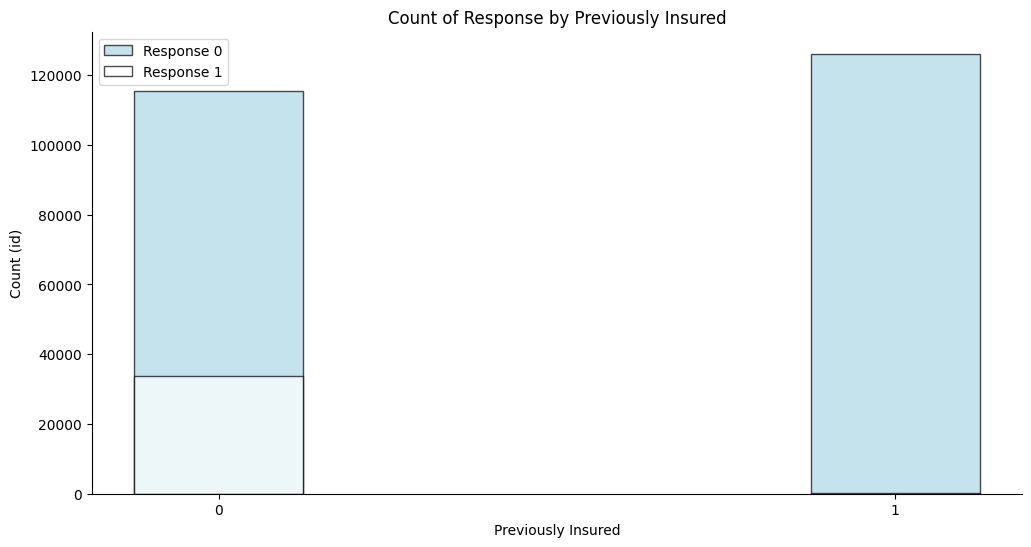

In [41]:
# Data
df_grouped = df1_train[['id', 'previously_insured', 'response']].groupby(['previously_insured', 'response']).count().reset_index()

# Extracting data for each response
response_0 = df_grouped[df_grouped['response'] == 0]
response_1 = df_grouped[df_grouped['response'] == 1]

# Adjust figure width
fig, ax = plt.subplots(figsize=(12, 6))

# Width of the bars
bar_width = 0.25

# Plotting bar chart
plt.bar(response_0['previously_insured'], response_0['id'], width=bar_width, label='Response 0', alpha=0.7, color='lightblue', edgecolor='black')
plt.bar(response_1['previously_insured'], response_1['id'], width=bar_width, label='Response 1', alpha=0.7, color='white', edgecolor='black')

# Adding labels and title
plt.xlabel('Previously Insured')
plt.ylabel('Count (id)')
plt.title('Count of Response by Previously Insured')

# Remove background grid
plt.grid(False)
# Remove the top and right axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Paint the y and x axes black
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Set x-axis ticks to only show 0 and 1
plt.xticks([0, 1])

# Adding legend
plt.legend()

# Display the plot
plt.show()


Figure 7. Response by previously insured

### 4.1.6 Vehicle Age

In [23]:
df1_train[['id','vehicle_age','response']].groupby(['vehicle_age','response']).count().reset_index()


,vehicle_age,response,id
0,below_1_year,0,113982
1,below_1_year,1,5178
2,between_1_2_years,0,119498
3,between_1_2_years,1,25229
4,over_2_years,0,8123
5,over_2_years,1,3340


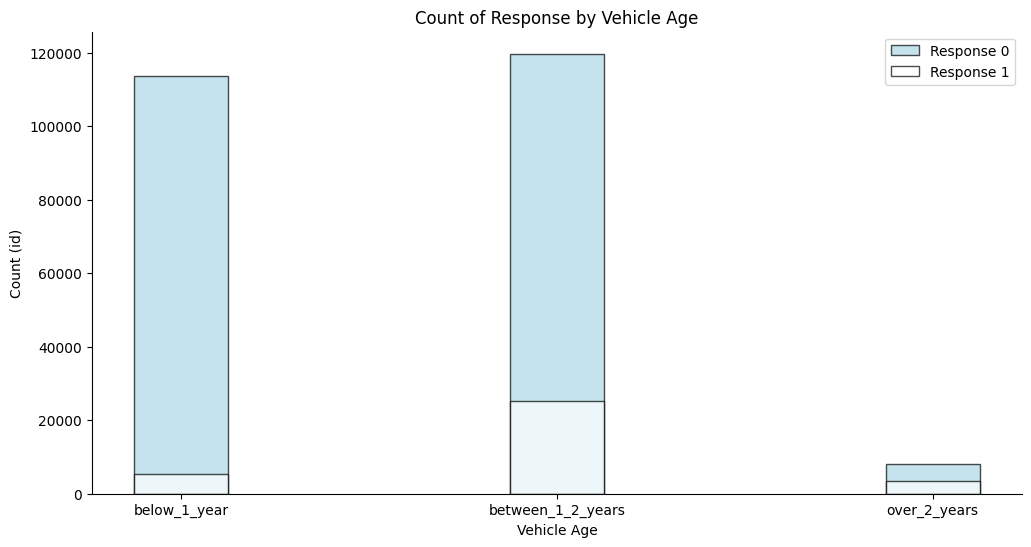

In [43]:
# Data
df_grouped = df1_train[['id','vehicle_age','response']].groupby(['vehicle_age','response']).count().reset_index()

# Extracting data for each response
response_0 = df_grouped[df_grouped['response'] == 0]
response_1 = df_grouped[df_grouped['response'] == 1]

# Adjust figure width
fig, ax = plt.subplots(figsize=(12, 6))

# Width of the bars
bar_width = 0.25

# Plotting bar chart
# plt.bar(response_0['vehicle_age'] - bar_width/2, response_0['id'], width=bar_width, label='Response 0', alpha=0.7)
# plt.bar(response_1['vehicle_age'] + bar_width/2, response_1['id'], width=bar_width, label='Response 1', alpha=0.7)

plt.bar(response_0['vehicle_age'] , response_0['id'], width=bar_width, label='Response 0', alpha=0.7, color = 'lightblue', edgecolor='black')
plt.bar(response_1['vehicle_age'] , response_1['id'], width=bar_width, label='Response 1', alpha=0.7, color = 'white', edgecolor = 'black')

# Adding labels and title
plt.xlabel('Vehicle Age')
plt.ylabel('Count (id)')
plt.title('Count of Response by Vehicle Age')

# Remove background grid
plt.grid(False)
# Remove the top and right axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Paint the y and x axes black
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Set x-axis ticks to only show 0 and 1
# plt.xticks([0, 1])

# Adding legend
plt.legend()

# Display the plot
plt.show()


Figure 8. Count of Response by Vehicle Age.

### 4.1.7 Vehicle Damage

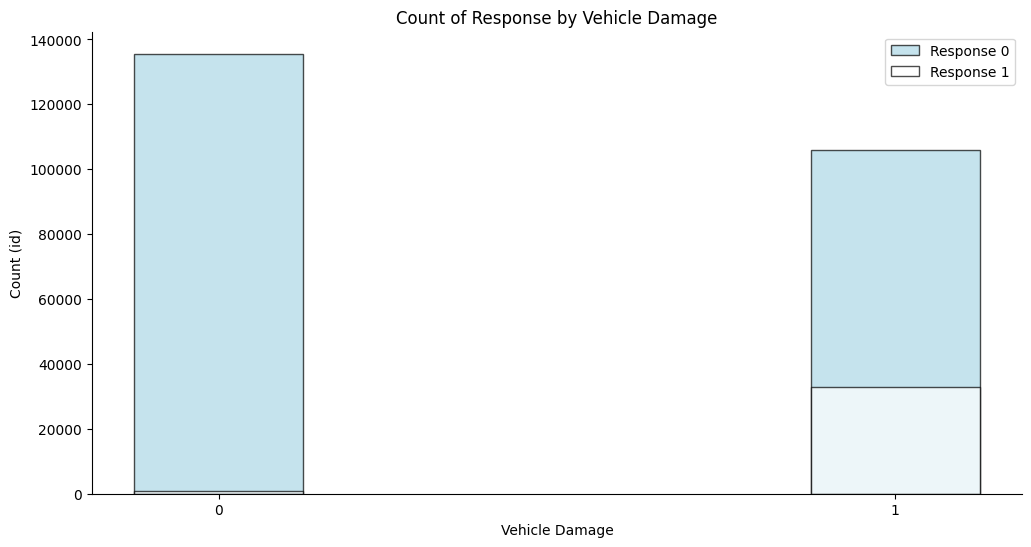

In [44]:
# Data
df_grouped = df1_train[['id', 'vehicle_damage', 'response']].groupby(['vehicle_damage', 'response']).count().reset_index()

# Extracting data for each response
response_0 = df_grouped[df_grouped['response'] == 0]
response_1 = df_grouped[df_grouped['response'] == 1]

# Adjust figure width
fig, ax = plt.subplots(figsize=(12, 6))

# Width of the bars
bar_width = 0.25

# Plotting bar chart
plt.bar(response_0['vehicle_damage'], response_0['id'], width=bar_width, label='Response 0', alpha=0.7, color='lightblue', edgecolor='black')
plt.bar(response_1['vehicle_damage'], response_1['id'], width=bar_width, label='Response 1', alpha=0.7, color='white', edgecolor='black')

# Adding labels and title
plt.xlabel('Vehicle Damage')
plt.ylabel('Count (id)')
plt.title('Count of Response by Vehicle Damage')

# Remove background grid
plt.grid(False)
# Remove the top and right axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Paint the y and x axes black
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Set x-axis ticks to only show 0 and 1
plt.xticks([0, 1])

# Adding legend
plt.legend()

# Display the plot
plt.show()


Figure 9. Count of response by vehicle damage.

### 4.1.8. Policy Sales Channel

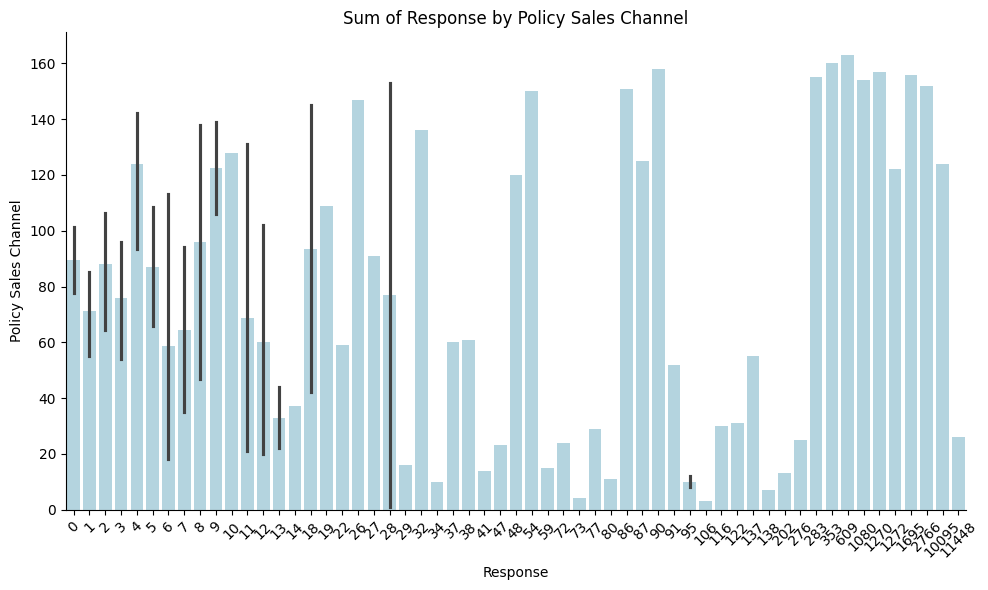

In [6]:
# Data
df_grouped = df1_train[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()

# Adjust figure width
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bar chart
sns.barplot(x='response', y='policy_sales_channel', data=df_grouped, ax=ax, color='lightblue')

# Adding labels and title
plt.xlabel('Response')
plt.ylabel('Policy Sales Channel')
plt.title('Sum of Response by Policy Sales Channel')

# Rotate x-axis labels and widen the chart
plt.xticks(rotation=45)
plt.tight_layout()

# Remove background grid
plt.grid(False)
# Remove the top and right axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Paint the y and x axes black
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')


# Show the plot
plt.show()


Figure 10. Sum of the response by policy sales channel.

### 4.1.9. Vintage

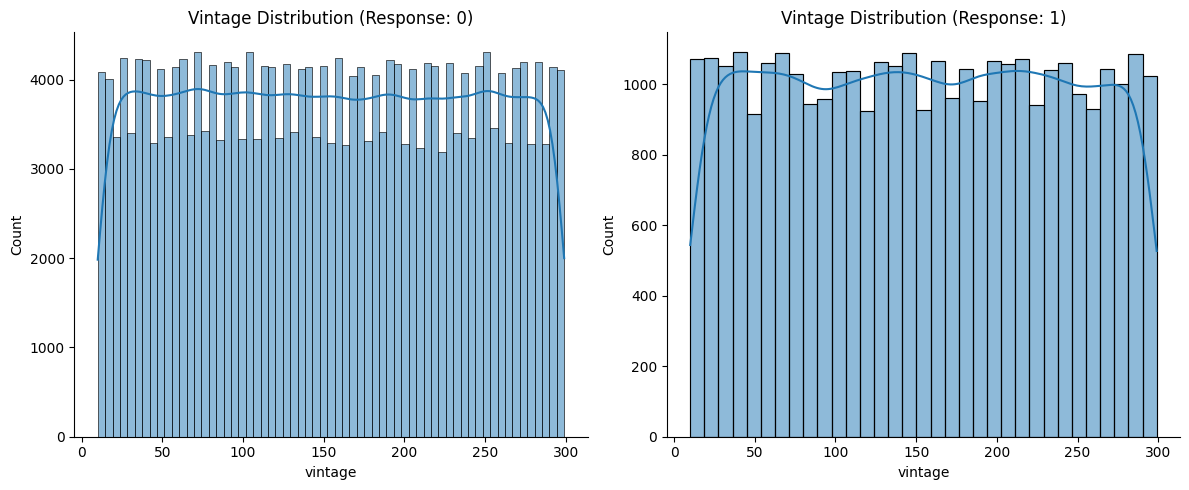

In [9]:
# Set up 1x2 grid for subplots
fig,axes = plt.subplots(1,2,figsize = (12,5))

# Chunk 1 - Histogram for annual_premium of those who don't want to buy
vintage_no = df1_train.loc[df1_train['response'] == 0, 'vintage']
sns.histplot(vintage_no, kde=True, ax=axes[0])
axes[0].set_title('Vintage Distribution (Response: 0)')
axes[0].grid(False)
# Remove the top and right axes
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
# Paint the y and x axes black
axes[0].spines['left'].set_color('black')
axes[0].spines['bottom'].set_color('black')

# Chunk 2 - Histogram for annual_premium of those who want to buy
vintage_yes = df1_train.loc[df1_train['response'] == 1, 'vintage']
sns.histplot(vintage_yes, kde=True, ax=axes[1])
axes[1].set_title('Vintage Distribution (Response: 1)')
axes[1].grid(False)
# Remove the top and right axes
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
# Paint the y and x axes black
axes[1].spines['left'].set_color('black')
axes[1].spines['bottom'].set_color('black')

# Adjust to prevent overlapping
plt.tight_layout()

# Show Plots
plt.show();


Figure 11. Response by the Vintage variable.

In [146]:
# Clean the environment for performance
del df1_train_ftr, fig,patch

## 4.2. Hypothesis

**H1 - The interest in the car insurance is pronounced for costumer with newer vehicles.**  

FALSE: The data show cars newer than 1 year, those that has been used between 1 and 2 years, and those cars older than two years. The hypothesis that owner with newer car would be interested in buying car insurance is false. The data show that owners of the intermediate group are the majority of interested in buying car insurance.

**H2 - Older clients are the ones interested in buying car insurance**  
**FALSE** - Clients with age between 40 and 55 are the ones most interested in car insurance.

**H3 - Clients who were previously insured were the ones interested in buying car insurance**  
**FALSE** - Clients that have shown interest are those with no prior car insurance service.

# 5.0 Data Preparation

## 5.1. Standardization

**Training**

In [27]:
ss_train = pp.StandardScaler()

# Annual Premium - Standard Scaler Training
df1_train['annual_premium'] = ss_train.fit_transform(df1_train[['annual_premium']].values )
pickle.dump( ss_train, open( '../src/features/annual_premium_scaler_train.pkl', 'wb' ) )

**Validation**

In [28]:
ss_val = pp.StandardScaler()

# Annual Premium - Standard Scaler Validation
df1_val['annual_premium'] = ss_val.fit_transform(df1_val[['annual_premium']].values )
pickle.dump( ss_val, open( '../src/features/annual_premium_scaler_val.pkl', 'wb' ) )

## 5.2. Rescaling

**Training**

In [29]:
mms_age_train = pp.MinMaxScaler()
mms_vintage_train = pp.MinMaxScaler()

# Age - MinMaxScaler
df1_train['age'] = mms_age_train.fit_transform(df1_train[['age']].values)
pickle.dump(mms_age_train, open('../src/features/age_scaler_train.pkl', 'wb') )

# Vintage - MinMaxScaler
df1_train['vintage'] = mms_vintage_train.fit_transform(df1_train[['vintage']].values )
pickle.dump(mms_vintage_train, open('../src/features/vintage_scaler_train.pkl','wb') )

**Validation**

In [30]:
mms_age_val = pp.MinMaxScaler()
mms_vintage_val = pp.MinMaxScaler()

# Age - MinMaxScaler
df1_val['age'] = mms_age_val.fit_transform(df1_val[['age']].values)
pickle.dump(mms_age_val, open('../src/features/age_scaler_val.pkl', 'wb') )

# Vintage - MinMaxScaler
df1_val['vintage'] = mms_vintage_val.fit_transform(df1_val[['vintage']].values )
pickle.dump(mms_vintage_val, open('../src/features/vintage_scaler_val.pkl','wb') )

## 5.3. Transformation

**Training**

In [31]:
%%time
# Gender - OneHotEncoding/ Target encoding
target_encode_gender_train = df1_train.groupby('gender')['response'].mean()
df1_train.loc[:, 'gender'] = df1_train['gender'].map(target_encode_gender_train )
pickle.dump( target_encode_gender_train, open('../src/features/target_encode_gender_scaler_train.pkl','wb'))
                                        
# Region_code - Target encoding/ Frequency encoding
target_encode_region_code_train = df1_train.groupby('region_code')['response'].mean()
df1_train.loc[:, 'region_code'] = df1_train['region_code'].map(target_encode_region_code_train )
pickle.dump( target_encode_region_code_train, open('../src/features/target_encode_region_code_scaler_train.pkl','wb'))
                                        
# vehicle_age - OneHotEncoding/ Frequency Encoding
df1_train = pd.get_dummies(df1_train, prefix='vehicle_age', columns=['vehicle_age'] )
                                        
# policy_sales_channel - target encoding / Frequency encoding
fe_policy_sales_channel_train = df1_train.groupby( 'policy_sales_channel' ).size()/len(df1_train)
df1_train.loc[:,'policy_sales_channel'] = df1_train['policy_sales_channel'].map(fe_policy_sales_channel_train )
pickle.dump(fe_policy_sales_channel_train, open('../src/features/fe_policy_sales_channel_scaler_train.pkl','wb' ))

CPU times: user 173 ms, sys: 3.98 ms, total: 177 ms
Wall time: 176 ms


**Validation**

In [32]:
%%time
# Gender - OneHotEncoding/ Target encoding
target_encode_gender_val = df1_val.groupby('gender')['response'].mean()
df1_val.loc[:, 'gender'] = df1_val['gender'].map(target_encode_gender_val )
pickle.dump( target_encode_gender_val, open('../src/features/target_encode_gender_scaler_val.pkl','wb'))
                                        
# Region_code - Target encoding/ Frequency encoding
target_encode_region_code_val = df1_val.groupby('region_code')['response'].mean()
df1_val.loc[:, 'region_code'] = df1_val['region_code'].map(target_encode_region_code_val )
pickle.dump( target_encode_region_code_val, open('../src/features/target_encode_region_code_scaler_val.pkl','wb'))
                                        
# vehicle_age - OneHotEncoding/ Frequency Encoding
df1_val = pd.get_dummies(df1_val, prefix='vehicle_age', columns=['vehicle_age'] )
                                        
# policy_sales_channel - target encoding / Frequency encoding
fe_policy_sales_channel_val = df1_val.groupby( 'policy_sales_channel' ).size()/len(df1_val)
df1_val.loc[:,'policy_sales_channel'] = df1_val['policy_sales_channel'].map(fe_policy_sales_channel_val )
pickle.dump(fe_policy_sales_channel_val, open('../src/features/fe_policy_sales_channel_scaler_val.pkl','wb' ))

CPU times: user 58.4 ms, sys: 508 µs, total: 58.9 ms
Wall time: 57.1 ms


# 6.0 Feature Selection

## 6.1. Boruta Algorithm

In [38]:
X_train = df1_train.drop(['id','response'], axis = 1).values
y_train = df1_train['response'].copy().values.ravel()


In [39]:
%%time
# Define model
et = en.ExtraTreesClassifier( n_jobs = -1 )

CPU times: user 41 µs, sys: 16 µs, total: 57 µs
Wall time: 60.8 µs


In [40]:
%%time
# Define Boruta
boruta = bt.BorutaPy( et, n_estimators = 'auto', verbose=2, random_state=42)

CPU times: user 12 µs, sys: 5 µs, total: 17 µs
Wall time: 19.1 µs


In [41]:
%%time
boruta.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

BorutaPy(estimator=ExtraTreesClassifier(n_estimators=20, n_jobs=-1,
                                        random_state=RandomState(MT19937) at 0x7F5CD9FE2840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F5CD9FE2840, verbose=2)

In [42]:
cols_selected = boruta.support_.tolist()


In [43]:
# Best features
x_train_fs = df1_train.drop(['id','response'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# Not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta))

## 6.2. Feature Importance

In [44]:
 # model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
# x_train_n = df5.drop( ['id', 'response'], axis=1 )
# y_train_n = y_train.values
forest.fit( X_train, y_train )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [45]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [46]:
# Print the feature ranking
print("Feature ranking:")
feature_importances = []
for feature, importance in zip(df1_train, forest.feature_importances_):
    feature_importances.append({'feature': feature, 'importance': importance})

df = pd.DataFrame(feature_importances)
print(df.sort_values('importance', ascending=False))


Feature ranking:
                     feature  importance
8             annual_premium    0.271353
7         previously_insured    0.242750
1                     gender    0.168673
2                        age    0.103759
5            driving_license    0.068062
3                region_code    0.060296
6             vehicle_damage    0.056486
9                    vintage    0.014034
10                  response    0.006537
0                         id    0.005368
11  vehicle_age_below_1_year    0.002147
4       policy_sales_channel    0.000537


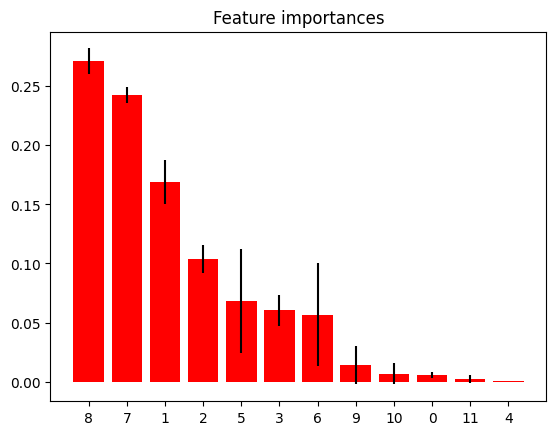

In [47]:
# Plot the impurity-based feature importances of the forest
df_fi = df1_train.drop(['vehicle_age_between_1_2_years', 'vehicle_age_over_2_years'], axis = 1)
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_fi.shape[1]), importances[indices],color='r', yerr=std[indices],align='center')
plt.xticks(range(df_fi.shape[1]), indices)
plt.xlim([-1, df_fi.shape[1]])
plt.show();

Figure 12. Selected features after analysis.

## 6.2.1. Prepare and save data for optimizig future processing

In [33]:
cols_selected = ['previously_insured','gender', 'age', 
                 'driving_license','region_code', 'vehicle_damage']

In [34]:
X_train = df1_train[cols_selected]
X_train['gender'] = X_train['gender'].astype(float)

x_val = df1_val[cols_selected]
x_val['gender'] = x_val['gender'].astype(float)
y_val = df1_val['response']

/tmp/ipykernel_36331/4146029114.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36331/4146029114.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 7.0 Machine Learning modelling

## 7.1 kNN Classifier

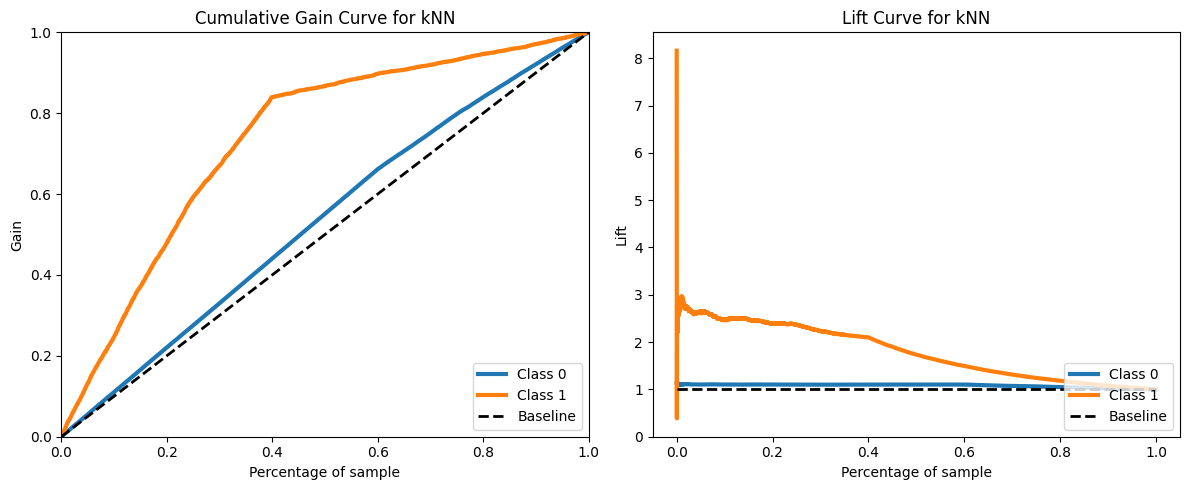

In [36]:
# model definition

knn_model = nh.KNeighborsClassifier (n_neighbors = 7)

# model training

knn_model.fit(X_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)


# Create a 1x2 grid
fig, axes = plt.subplots(1,2,figsize=(12,5))

# Cumulative gain kNN
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve for kNN')
axes[0].grid(False)

#lift curve kNN
skplt.metrics.plot_lift_curve(y_val,yhat_knn, ax=axes[1])
axes[1].set_title('Lift Curve for kNN')
axes[1].grid(False)

plt.tight_layout()
plt.show()

Figure 13. Cumulative gain and lift curve for the kNN model.

### 7.1.1. Model Evaluation

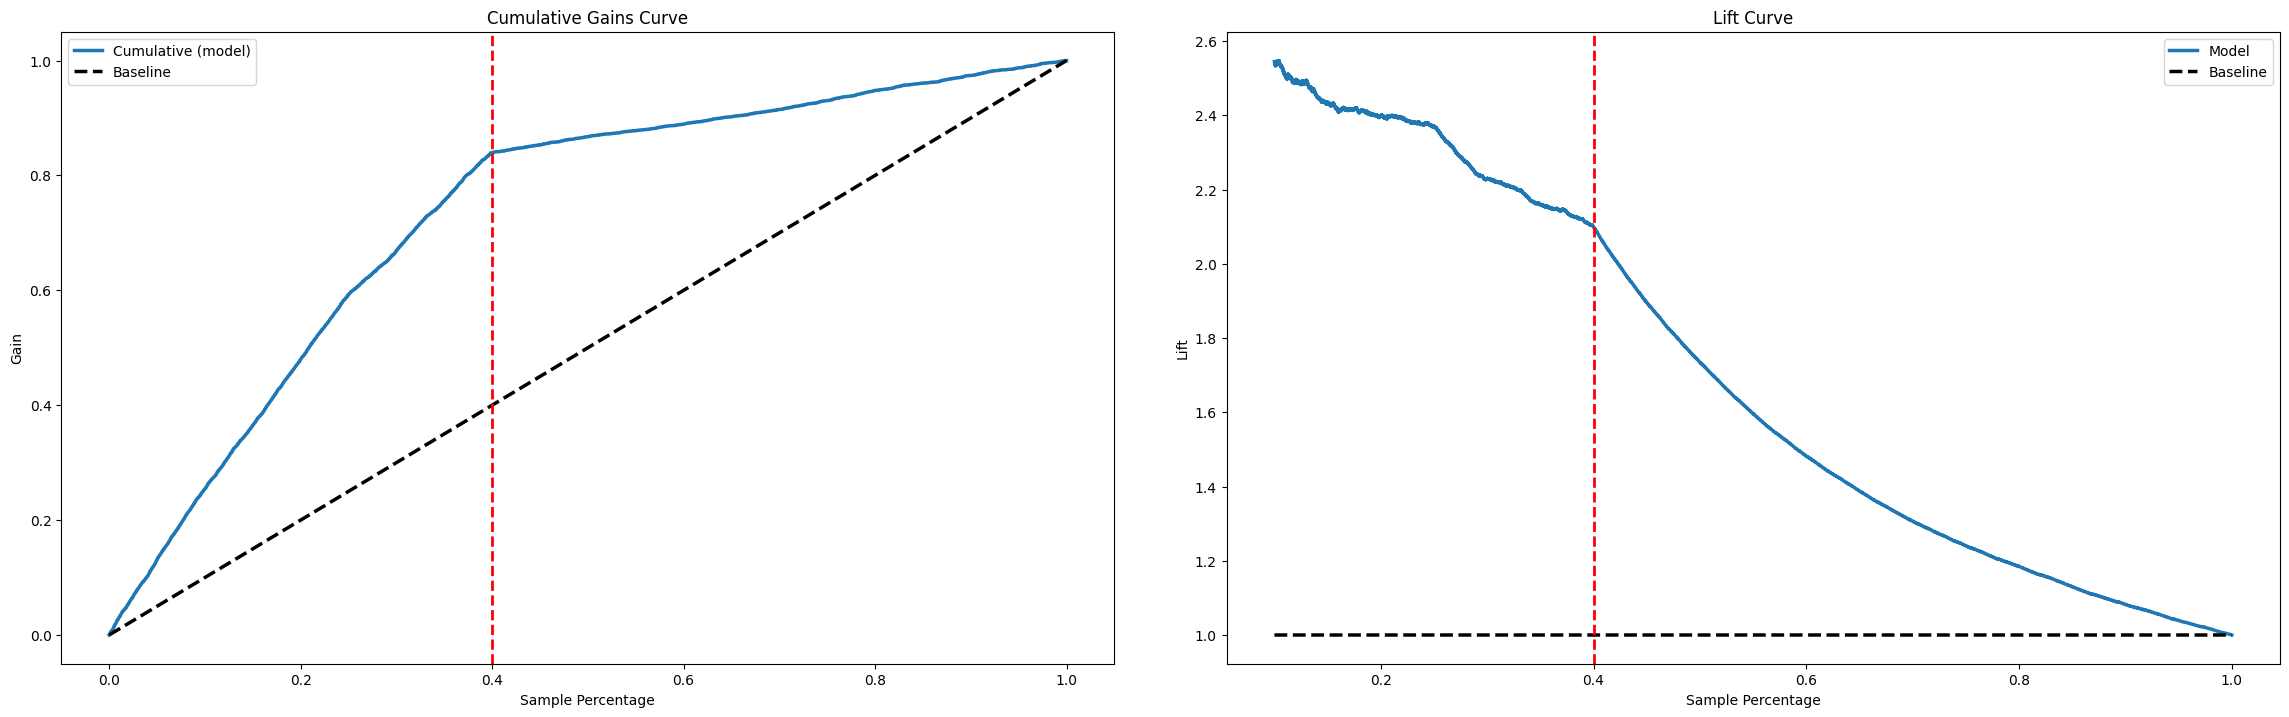

In [39]:
# Using function
table_knn = gain_lift_curve(yhat_knn, y_val,axvline=0.4)

Figure 14. Cumulative gain and lift curve for kNN.

### 7.1.2. Precision and Recall kNN

In [52]:
metrics_knn, new_table_knn = precision_recall_at_k(table_knn, 27440)

In [53]:
new_table_knn

,0,1,target,correct,propensity_score,cumulative_propensity_score,cum_perc_base,lift,ranking,precision_at_k,recall_at_k
0,0.142857,0.857143,1,yes,0.000168,0.000168,0.000021,8.158496,1,1.000000,0.000168
1,0.142857,0.857143,0,no,0.000000,0.000168,0.000041,4.079248,2,0.500000,0.000168
2,0.142857,0.857143,0,no,0.000000,0.000168,0.000062,2.719499,3,0.333333,0.000168
3,0.142857,0.857143,1,yes,0.000168,0.000336,0.000082,4.079248,4,0.500000,0.000336
4,0.142857,0.857143,0,no,0.000000,0.000336,0.000103,3.263398,5,0.400000,0.000336
...,...,...,...,...,...,...,...,...,...,...,...
48587,1.000000,0.000000,0,yes,0.000000,0.999832,0.999918,0.999914,48588,0.122561,0.999832
48588,1.000000,0.000000,1,no,0.000168,1.000000,0.999938,1.000062,48589,0.122579,1.000000
48589,1.000000,0.000000,0,yes,0.000000,1.000000,0.999959,1.000041,48590,0.122577,1.000000
48590,1.000000,0.000000,0,yes,0.000000,1.000000,0.999979,1.000021,48591,0.122574,1.000000


In [54]:
print(f"KNN - \nPrecision at 40% of base(k): {round( metrics_knn[0] ,2)}\nRecall at 40% of base(k): {round( metrics_knn[1] ,2) }")

KNN - 
Precision at 40% of base(k): 0.19
Recall at 40% of base(k): 0.89


### 7.1.3. Cross Validation kNN

In [55]:
knn_cv = runCrossValidation ( knn_model, X_train, x_val, pd.Series(y_train), pd.Series(y_val), 5, 5, top_k = 27440, verbose = False )
knn_cv

,mean,std
precision_at_k,0.252754,0.001689
recall_at_k,0.873430,0.005837


## 7.2. Logistic Regression

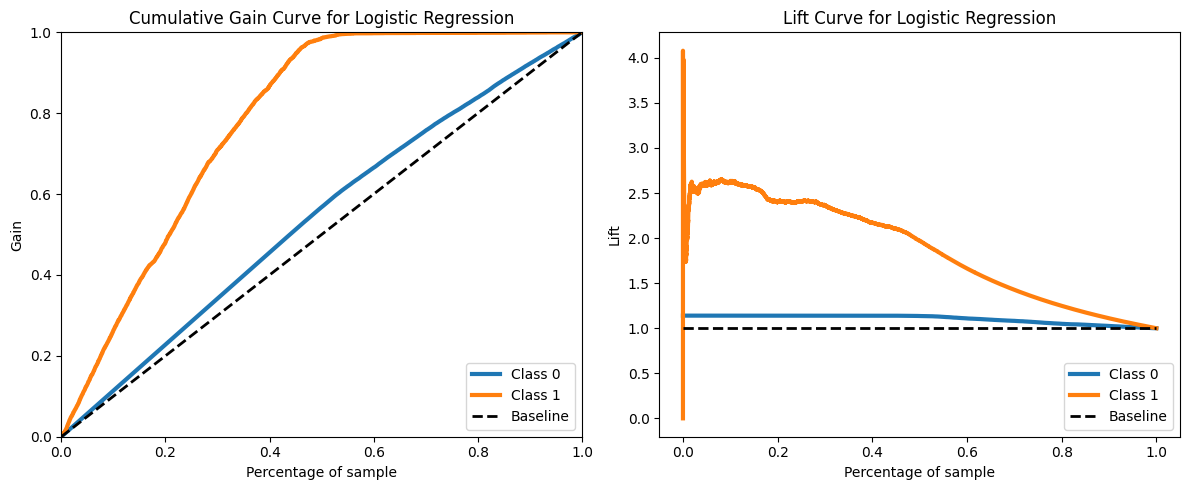

In [40]:
#Model definition
lr_model = lm.LogisticRegression(random_state = 42)

#Model training
lr_model.fit(X_train, y_train)

#Model prediction
yhat_lr = lr_model.predict_proba(x_val)

# Create a 1x2 grid
fig, axes = plt.subplots(1,2,figsize=(12,5))

#Cumulative gain Logistic Regression
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve for Logistic Regression')
axes[0].grid(False)

#Lift curve Logistic regression
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax=axes[1])
axes[1].set_title('Lift Curve for Logistic Regression')
axes[1].grid(False)

plt.tight_layout()
plt.show()

Figure 15. Cumulative gain and lift curve for Logistic Regression.

### 7.2.1. Model Evaluation Logistic Regression

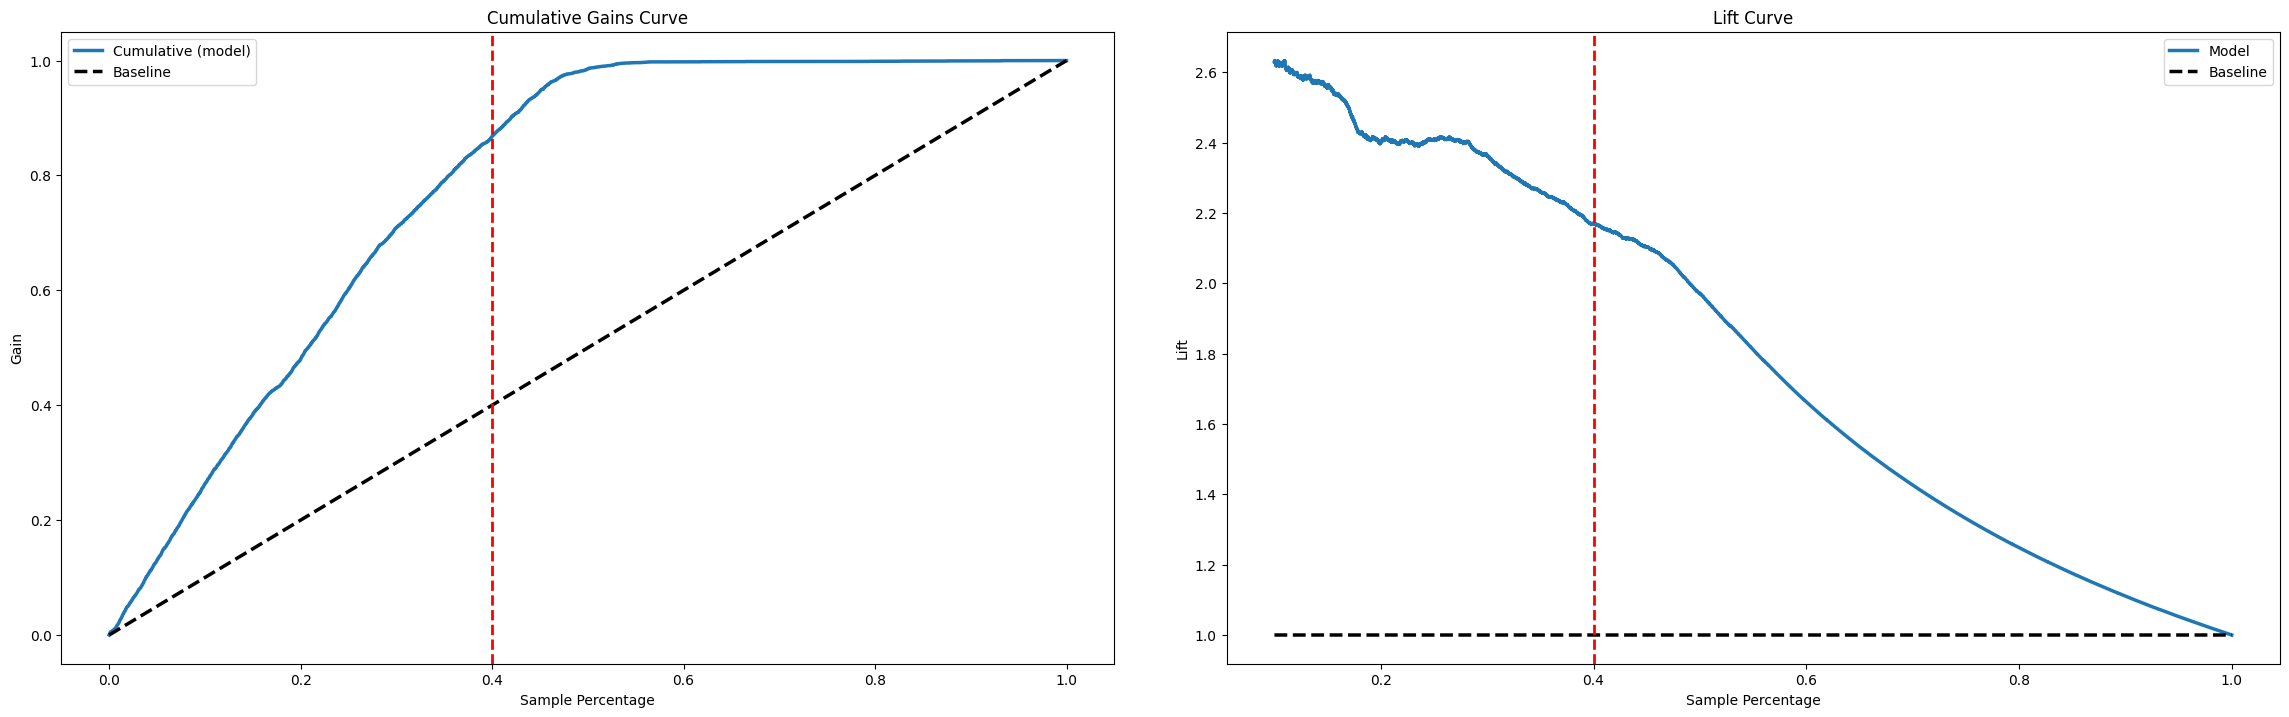

In [41]:
table_lr = gain_lift_curve(yhat_lr, y_val, axvline=0.4)

Figure 16. Cumulative gain and lift curve for the Logistic Regression.

### 7.2.2. Precision and Recall Logistic Regression

In [58]:
metrics_lr, new_table_lr = precision_recall_at_k(table_lr, 27440) #27440 corresponds to 40% of the customer base.

new_table_lr

,0,1,target,correct,propensity_score,cumulative_propensity_score,cum_perc_base,lift,ranking,precision_at_k,recall_at_k
0,0.664739,0.335261,0,yes,0.000000,0.000000,0.000021,0.000000,1,0.000000,0.000000
1,0.664739,0.335261,0,yes,0.000000,0.000000,0.000041,0.000000,2,0.000000,0.000000
2,0.665373,0.334627,0,yes,0.000000,0.000000,0.000062,0.000000,3,0.000000,0.000000
3,0.665689,0.334311,1,no,0.000168,0.000168,0.000082,2.039624,4,0.250000,0.000168
4,0.666006,0.333994,0,yes,0.000000,0.000168,0.000103,1.631699,5,0.200000,0.000168
...,...,...,...,...,...,...,...,...,...,...,...
48587,0.999734,0.000266,0,yes,0.000000,1.000000,0.999918,1.000082,48588,0.122582,1.000000
48588,0.999742,0.000258,0,yes,0.000000,1.000000,0.999938,1.000062,48589,0.122579,1.000000
48589,0.999754,0.000246,0,yes,0.000000,1.000000,0.999959,1.000041,48590,0.122577,1.000000
48590,0.999756,0.000244,0,yes,0.000000,1.000000,0.999979,1.000021,48591,0.122574,1.000000


In [59]:
print(f"Logistic Regression - \nPrecision at 40% of base(k): {round( metrics_lr[0] ,2)}\nRecall at 40% of base(k): {round( metrics_lr[1] ,2) }")


Logistic Regression - 
Precision at 40% of base(k): 0.22
Recall at 40% of base(k): 1.0


### 7.2.3. Cross Validation Logistic Regression

In [60]:
lr_cv = runCrossValidation ( lr_model, X_train, x_val, pd.Series(y_train), pd.Series(y_val), 5, 5, top_k = 27440, verbose = True )
lr_cv

training_lenght:259153
validation_lenght:64789


Iteration number1
(0.26104227405247815, 0.9020274524619065)

Iteration number2
(0.25943877551020406, 0.8964865885908576)

Iteration number3
(0.25965743440233235, 0.8972421609369097)

Iteration number4
(0.2587827988338192, 0.8943324937027708)

Iteration number5
(0.2616253644314869, 0.9041561712846348)

Iteration number6
(0.258564139941691, 0.893464299206649)

Iteration number7
(0.25790816326530613, 0.8911975821684927)

Iteration number8
(0.258564139941691, 0.893464299206649)

Iteration number9
(0.2584548104956268, 0.8931989924433249)

Iteration number10
(0.25918367346938775, 0.8957178841309824)

Iteration number11
(0.26118804664723033, 0.9025311673592746)

Iteration number12
(0.2582725947521866, 0.8924568694119128)

Iteration number13
(0.26253644314868807, 0.9071905301599295)

Iteration number14
(0.26224489795918365, 0.9062972292191436)

Iteration number15
(0.2563046647230321, 0.8857682619647356)

Iteration number16
(0.2599125364431487, 0

,mean,std
precision_at_k,0.259394,0.001735
recall_at_k,0.896376,0.006004


## 7.3. Random Forest

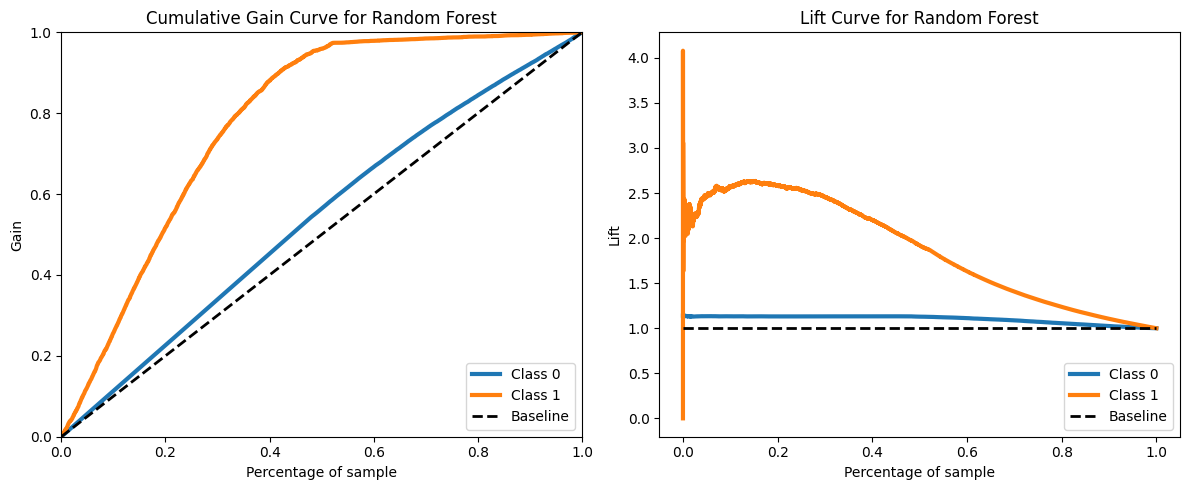

In [42]:
# model definition
rf = en.RandomForestClassifier( n_estimators = 1000, n_jobs = -1, random_state = 42)

# model training
rf.fit(X_train, y_train)

# model prediction
yhat_rf = rf.predict_proba( x_val )

# Create a 1x2 grid
fig, axes = plt.subplots(1,2,figsize=(12,5))

#Cumulative gain Random Forest
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve for Random Forest')
axes[0].grid(False)

#Lift curve Random Forest
skplt.metrics.plot_lift_curve( y_val, yhat_rf, ax=axes[1])
axes[1].set_title('Lift Curve for Random Forest')
axes[1].grid(False)

plt.tight_layout()
plt.show()

Figure 17. Cumulative gain and liftcurve for the random forest.

### 7.3.1 Model Evaluation Random Forest

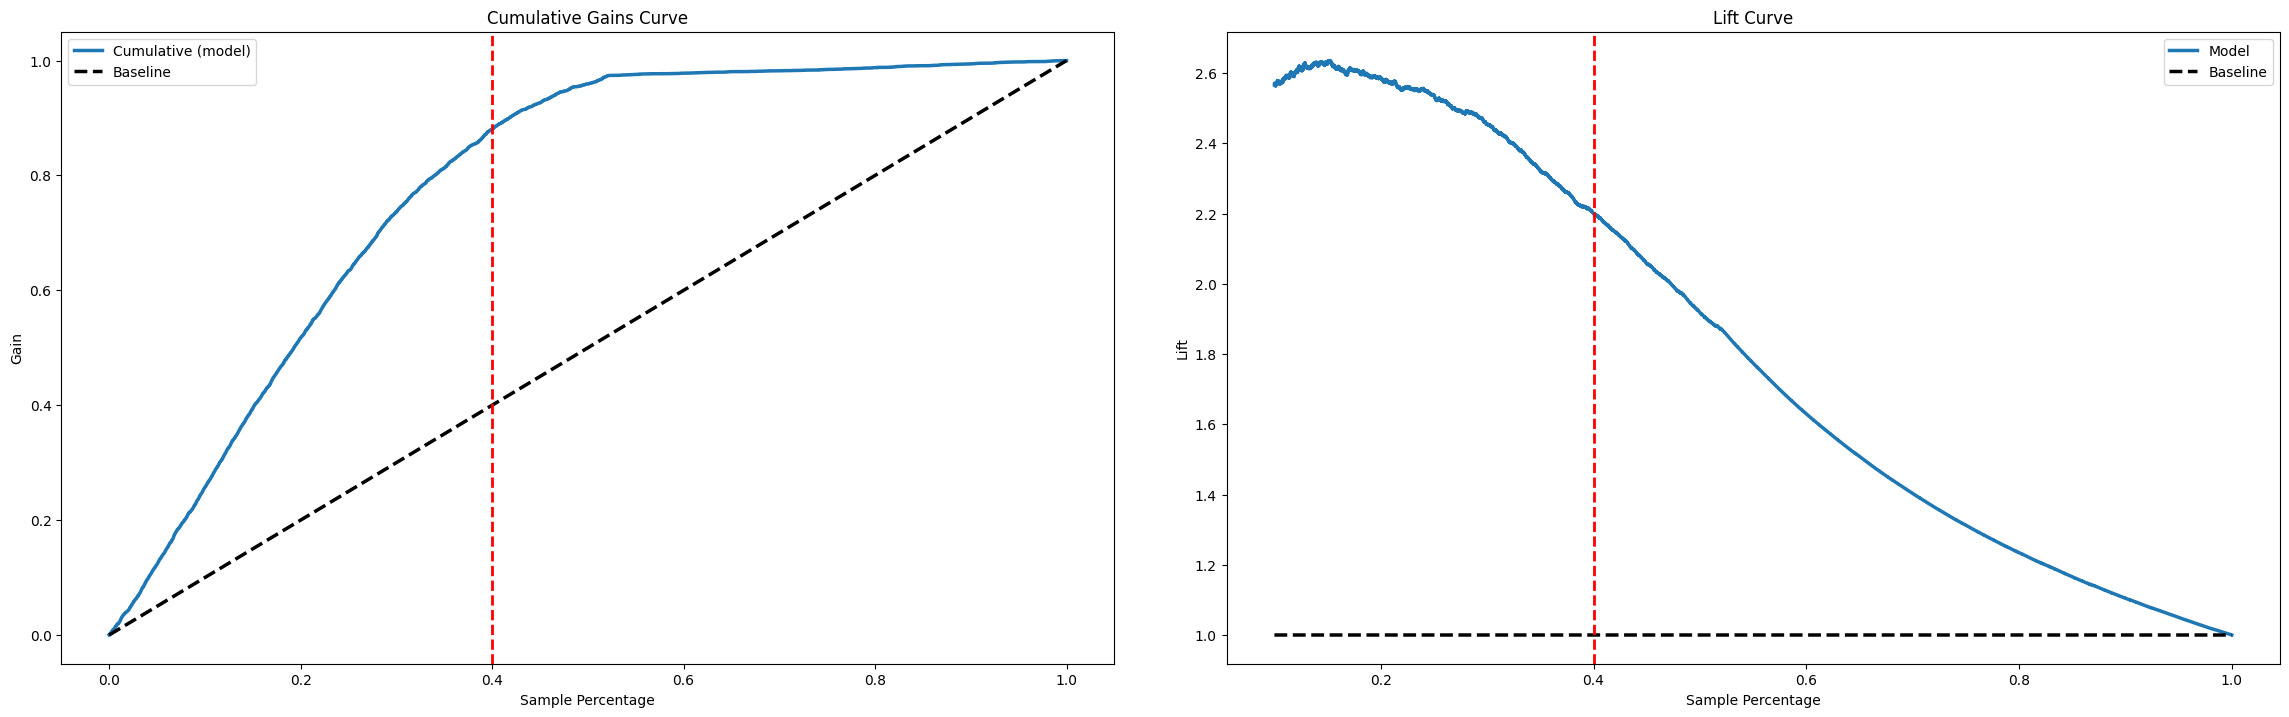

In [43]:
table_rf = gain_lift_curve(yhat_rf, y_val, axvline=0.4)

Figure 18. Cumulative gaind and lift curve for the random forest.

### 7.3.2. Precision and Recall Random Forest

In [63]:
metrics_rf, new_table_rf = precision_recall_at_k(table_rf, 27440) #27440 corresponds to 40% of the customer base.

new_table_rf

,0,1,target,correct,propensity_score,cumulative_propensity_score,cum_perc_base,lift,ranking,precision_at_k,recall_at_k
0,0.005007,0.994993,0,no,0.000000,0.000000,0.000021,0.000000,1,0.000000,0.000000
1,0.005007,0.994993,0,no,0.000000,0.000000,0.000041,0.000000,2,0.000000,0.000000
2,0.005007,0.994993,1,yes,0.000168,0.000168,0.000062,2.719499,3,0.333333,0.000168
3,0.030566,0.969434,0,no,0.000000,0.000168,0.000082,2.039624,4,0.250000,0.000168
4,0.030566,0.969434,0,no,0.000000,0.000168,0.000103,1.631699,5,0.200000,0.000168
...,...,...,...,...,...,...,...,...,...,...,...
48587,1.000000,0.000000,0,yes,0.000000,1.000000,0.999918,1.000082,48588,0.122582,1.000000
48588,1.000000,0.000000,0,yes,0.000000,1.000000,0.999938,1.000062,48589,0.122579,1.000000
48589,1.000000,0.000000,0,yes,0.000000,1.000000,0.999959,1.000041,48590,0.122577,1.000000
48590,1.000000,0.000000,0,yes,0.000000,1.000000,0.999979,1.000021,48591,0.122574,1.000000


In [64]:
print(f"Random Forest - \nPrecision at 40% of base(k): {round( metrics_rf[0] ,2)}\nRecall at 40% of base(k): {round( metrics_rf[1] ,2) }")


Random Forest - 
Precision at 40% of base(k): 0.21
Recall at 40% of base(k): 0.97


### 7.3.3. Cross Validation Random Forest

In [65]:
rf_cv = runCrossValidation ( rf, X_train, x_val, pd.Series(y_train), pd.Series(y_val), 5, 5, top_k = 27440, verbose = True )
rf_cv

training_lenght:259153
validation_lenght:64789


Iteration number1
(0.26198979591836735, 0.9053015992947991)

Iteration number2
(0.2627551020408163, 0.9079461025059816)

Iteration number3
(0.2625728862973761, 0.9073164588842715)

Iteration number4
(0.26231778425655977, 0.9065491183879093)

Iteration number5
(0.2615524781341108, 0.903904282115869)

Iteration number6
(0.26239067055393583, 0.9066868152625613)

Iteration number7
(0.2630466472303207, 0.9089535323007178)

Iteration number8
(0.26446793002915453, 0.9138647525500566)

Iteration number9
(0.26184402332361517, 0.904911838790932)

Iteration number10
(0.2628644314868805, 0.9084382871536524)

Iteration number11
(0.26129737609329445, 0.9029089535323007)

Iteration number12
(0.2625728862973761, 0.9073164588842715)

Iteration number13
(0.2629008746355685, 0.9084498174033497)

Iteration number14
(0.2633381924198251, 0.9100755667506297)

Iteration number15
(0.26246355685131195, 0.9070528967254408)

Iteration number16
(0.2639212827988338, 

,mean,std
precision_at_k,0.262529,0.000745
recall_at_k,0.907211,0.002566


## 7.4. LGBM

[LightGBM] [Info] Number of positive: 33747, number of negative: 241603
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 275350, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122560 -> initscore=-1.968404
[LightGBM] [Info] Start training from score -1.968404


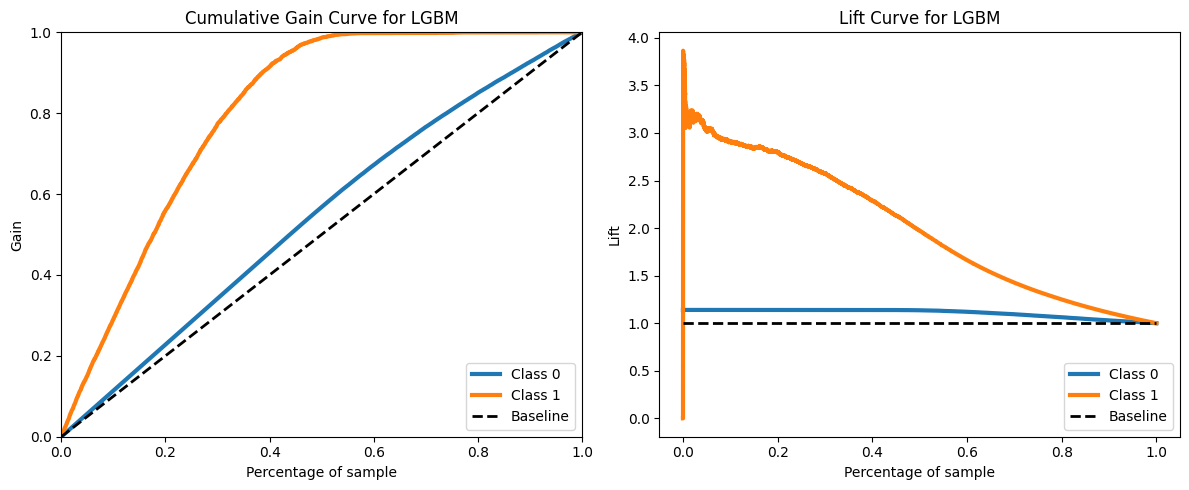

In [47]:
# model definition
lgbm_model = LGBMClassifier(random_state=0)

# model trainig
lgbm_model.fit( X_train, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( x_val )

# Create a 1x2 grid
fig, axes = plt.subplots(1,2,figsize=(12,5))

#Cumulative gain LGBM
skplt.metrics.plot_cumulative_gain (y_val, yhat_lgbm, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve for LGBM')
axes[0].grid(False)

#Lift curve LGBM
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm, ax=axes[1])
axes[1].set_title('Lift Curve for LGBM')
axes[1].grid(False)

plt.tight_layout()
plt.show()

Figure 18. Cumulative gain and lift curves for the LGBM.

### 7.4.1. Model Evaluation LGBM

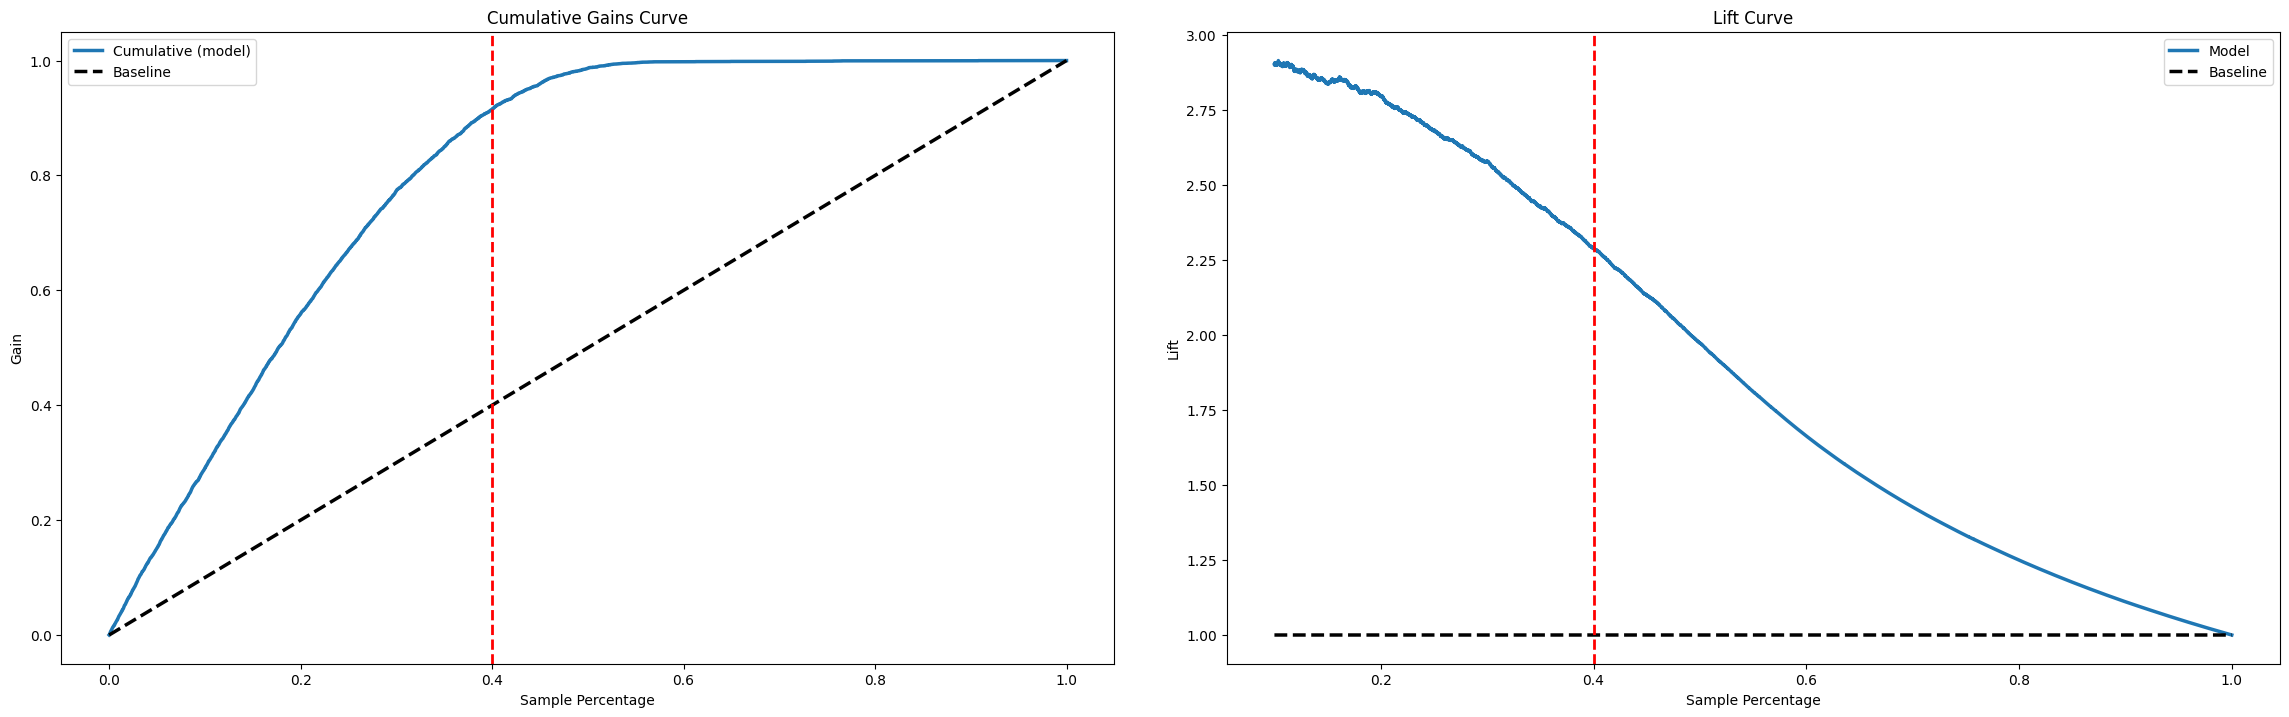

In [46]:
table_lgbm = gain_lift_curve(yhat_lgbm, y_val, axvline=0.4)

Figure 19. Cumulative gain and lift curve for the LGBM.

### 7.4.2. Precision and Recall LGBM

In [69]:
metrics_lgbm, new_table_lgbm = precision_recall_at_k(table_lgbm, 27440) #27440 corresponds to 40% of the customer base.

new_table_lgbm

,0,1,target,correct,propensity_score,cumulative_propensity_score,cum_perc_base,lift,ranking,precision_at_k,recall_at_k
0,0.518460,4.815401e-01,1,no,0.000168,0.000168,0.000021,8.158496,1,1.000000,0.000168
1,0.518460,4.815401e-01,0,yes,0.000000,0.000168,0.000041,4.079248,2,0.500000,0.000168
2,0.518460,4.815401e-01,1,no,0.000168,0.000336,0.000062,5.438997,3,0.666667,0.000336
3,0.518460,4.815401e-01,0,yes,0.000000,0.000336,0.000082,4.079248,4,0.500000,0.000336
4,0.518460,4.815401e-01,0,yes,0.000000,0.000336,0.000103,3.263398,5,0.400000,0.000336
...,...,...,...,...,...,...,...,...,...,...,...
48587,0.999999,5.356928e-07,0,yes,0.000000,1.000000,0.999918,1.000082,48588,0.122582,1.000000
48588,0.999999,5.356928e-07,0,yes,0.000000,1.000000,0.999938,1.000062,48589,0.122579,1.000000
48589,0.999999,5.356928e-07,0,yes,0.000000,1.000000,0.999959,1.000041,48590,0.122577,1.000000
48590,0.999999,5.356928e-07,0,yes,0.000000,1.000000,0.999979,1.000021,48591,0.122574,1.000000


In [70]:
print(f"LGBM - \nPrecision at 40% of base(k): {round( metrics_lgbm[0] ,2)}\nRecall at 40% of base(k): {round( metrics_lgbm[1] ,2) }")

LGBM - 
Precision at 40% of base(k): 0.22
Recall at 40% of base(k): 1.0


### 7.4.3. Cross Validation LGBM

In [71]:
lgbm_cv = runCrossValidation ( lgbm_model, X_train, x_val, pd.Series(y_train), pd.Series(y_val), 5, 5, top_k = 27440, verbose = False )
lgbm_cv

[LightGBM] [Info] Number of positive: 31762, number of negative: 227391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 259153, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122561 -> initscore=-1.968400
[LightGBM] [Info] Start training from score -1.968400
[LightGBM] [Info] Number of positive: 31762, number of negative: 227391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 259153, number of used features: 6
[LightGBM] [Info] 

,mean,std
precision_at_k,0.272315,0.000644
recall_at_k,0.941027,0.002227


## 7.5. Gradient Boost Classifier

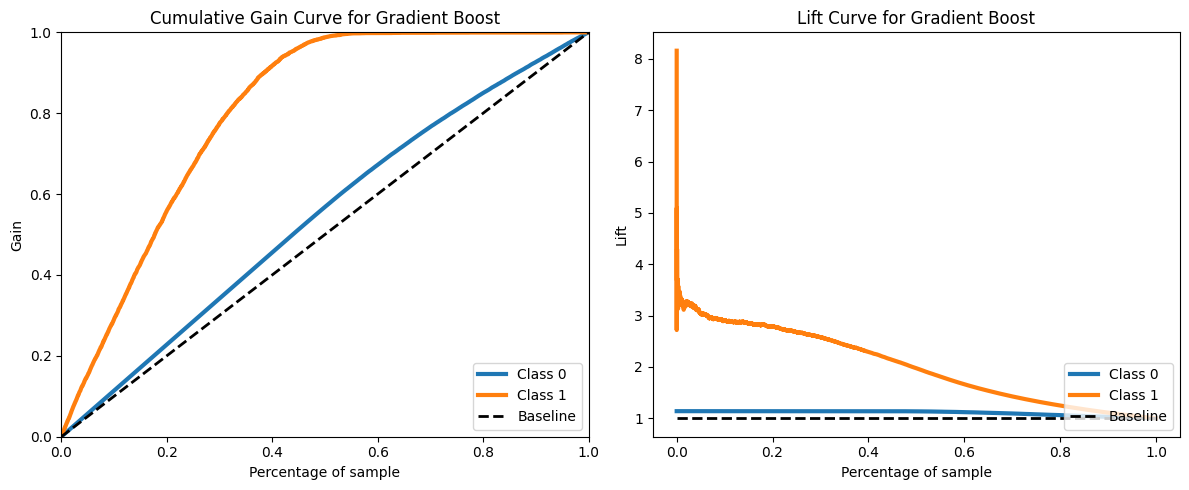

In [48]:
# model definition
grad_boost = en.GradientBoostingClassifier( random_state=42 )

# model training
grad_boost.fit( X_train, y_train )

# model selection
yhat_grad_boost = grad_boost.predict_proba( x_val )

# Create a 1x2 grid
fig, axes = plt.subplots(1,2,figsize=(12,5))

#Cumulative gain Gradient Boost
skplt.metrics.plot_cumulative_gain( y_val, yhat_grad_boost, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve for Gradient Boost')
axes[0].grid(False)

#Lift curve Gradient Boost
skplt.metrics.plot_lift_curve( y_val, yhat_grad_boost, ax=axes[1])
axes[1].set_title('Lift Curve for Gradient Boost')
axes[1].grid(False)

plt.tight_layout()
plt.show()

Figura 20. Cumulative gain and lift curve for the Gradient boost classifier.

### 7.5.1. Model Evaluation Gradient Boost Classifier

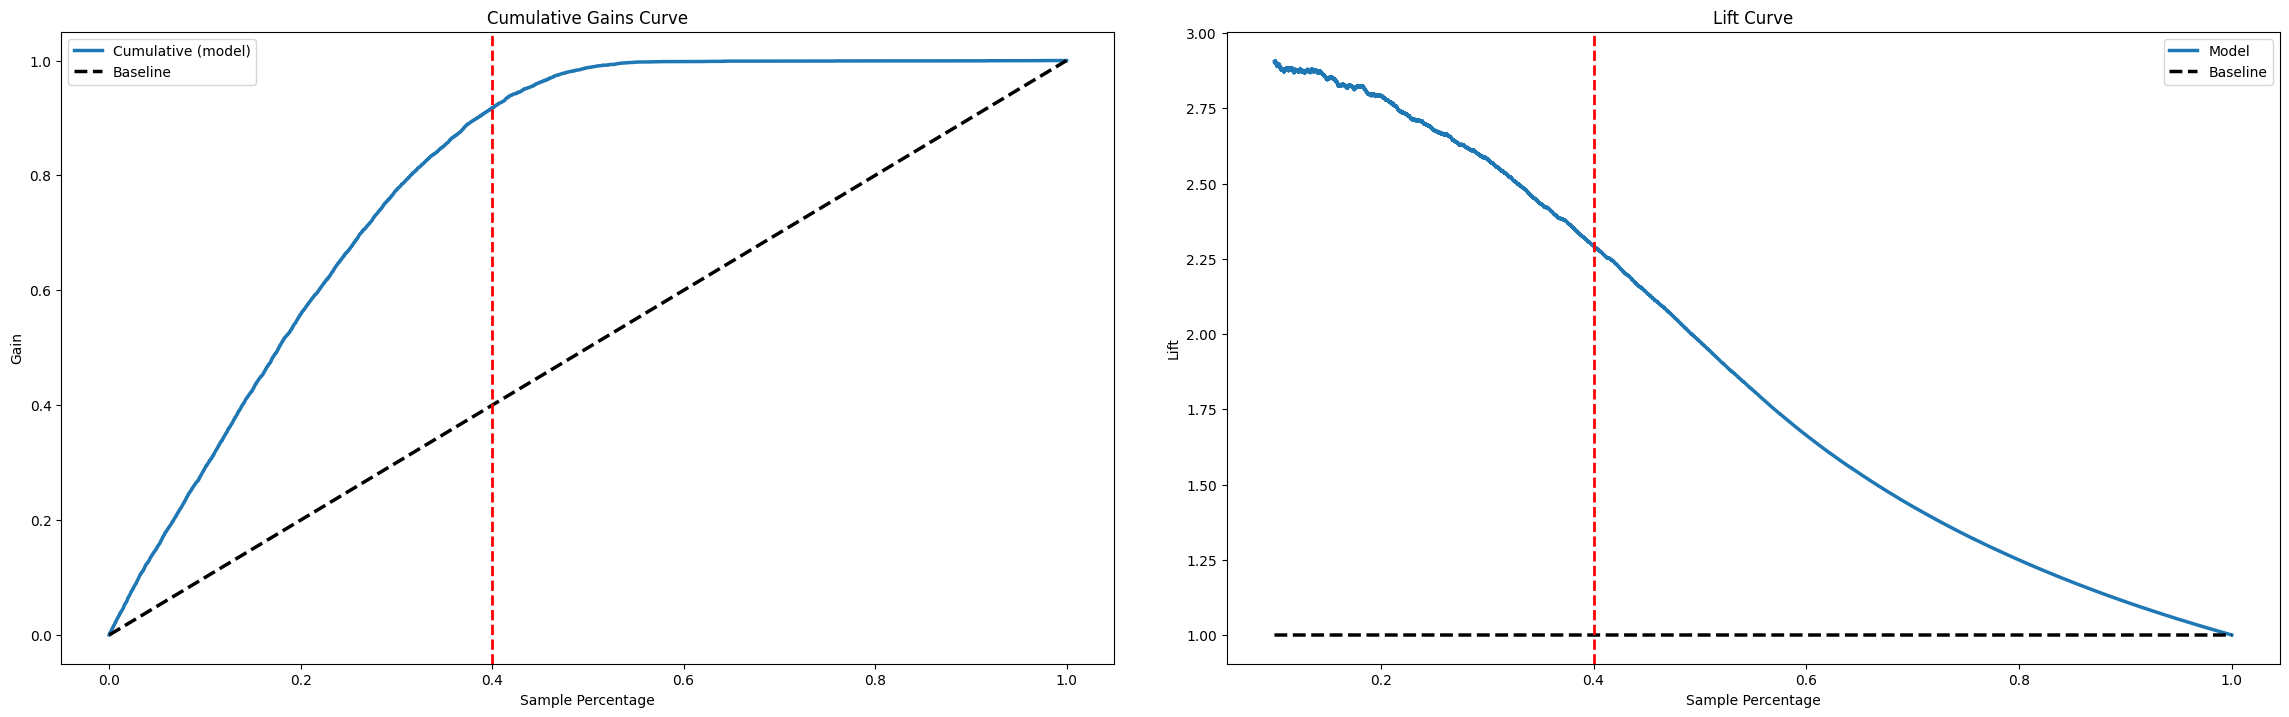

In [49]:
table_gb = gain_lift_curve(yhat_grad_boost, y_val, axvline=0.4)

Figure 21. Cumulative gain and lift curve for the Gradient boost classifier.

### 7.5.2. Precision and Recall Gradient Boost Classifier

In [74]:
metrics_gb, new_table_gb = precision_recall_at_k(table_gb, 27440) #27440 corresponds to 40% of the customer base.

new_table_gb

,0,1,target,correct,propensity_score,cumulative_propensity_score,cum_perc_base,lift,ranking,precision_at_k,recall_at_k
0,0.585285,0.414715,1,no,0.000168,0.000168,0.000021,8.158496,1,1.000000,0.000168
1,0.585285,0.414715,1,no,0.000168,0.000336,0.000041,8.158496,2,1.000000,0.000336
2,0.585285,0.414715,1,no,0.000168,0.000504,0.000062,8.158496,3,1.000000,0.000504
3,0.585285,0.414715,1,no,0.000168,0.000672,0.000082,8.158496,4,1.000000,0.000672
4,0.585285,0.414715,1,no,0.000168,0.000839,0.000103,8.158496,5,1.000000,0.000839
...,...,...,...,...,...,...,...,...,...,...,...
48587,0.999819,0.000181,0,yes,0.000000,1.000000,0.999918,1.000082,48588,0.122582,1.000000
48588,0.999846,0.000154,0,yes,0.000000,1.000000,0.999938,1.000062,48589,0.122579,1.000000
48589,0.999846,0.000154,0,yes,0.000000,1.000000,0.999959,1.000041,48590,0.122577,1.000000
48590,0.999848,0.000152,0,yes,0.000000,1.000000,0.999979,1.000021,48591,0.122574,1.000000


In [75]:
print(f"Gradient Boost Classifier - \nPrecision at 40% of base(k): {round( metrics_gb[0] ,2)}\nRecall at 40% of base(k): {round( metrics_gb[1] ,2) }")

Gradient Boost Classifier - 
Precision at 40% of base(k): 0.22
Recall at 40% of base(k): 1.0


### 7.5.3. Cross Validation Gradient Boost

In [76]:
gb_cv = runCrossValidation ( grad_boost, X_train, x_val, pd.Series(y_train), pd.Series(y_val), 5, 5, top_k = 27440, verbose = False )
gb_cv

,mean,std
precision_at_k,0.272306,0.000726
recall_at_k,0.940997,0.002519


## 7.6. XGBoost

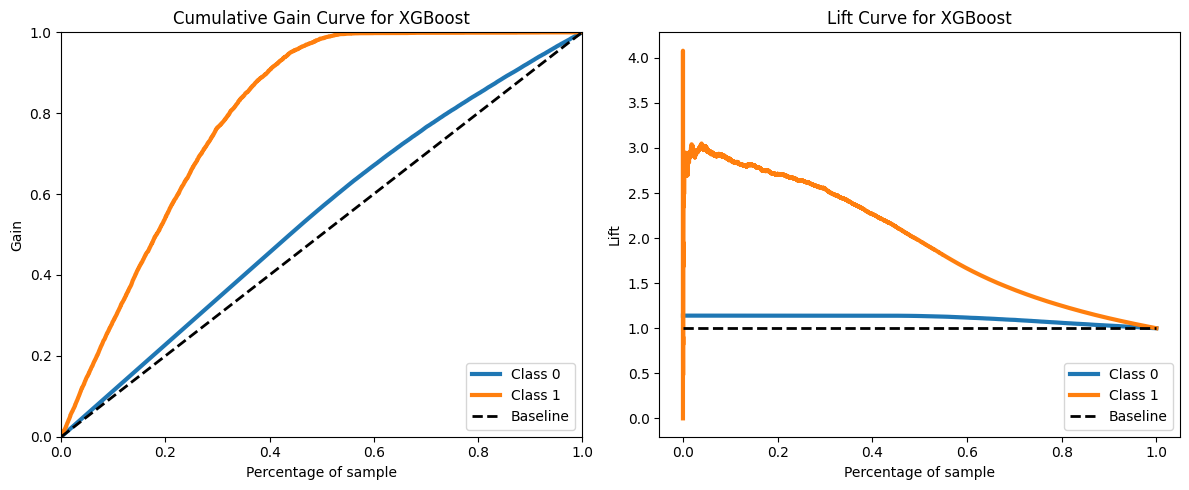

In [50]:
# model definition
xgb_model = xgb.XGBClassifier( n_jobs=-1, random_state = 42 )

# model training
xgb_model.fit (X_train, y_train )

# model prediction
yhat_xgb = xgb_model.predict_proba( x_val )

# Create a 1x2 grid
fig, axes = plt.subplots(1,2,figsize=(12,5))

#Cumulative gain XGBoost
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve for XGBoost')
axes[0].grid(False)

#Lift curve XGBoost
skplt.metrics.plot_lift_curve( y_val, yhat_xgb, ax=axes[1])
axes[1].set_title('Lift Curve for XGBoost')
axes[1].grid(False)

plt.tight_layout()
plt.show()

Figure 22. Cumulative gain and lift curve for the XGBoost model.

### 7.6.1. Model Evaluation XGBoost

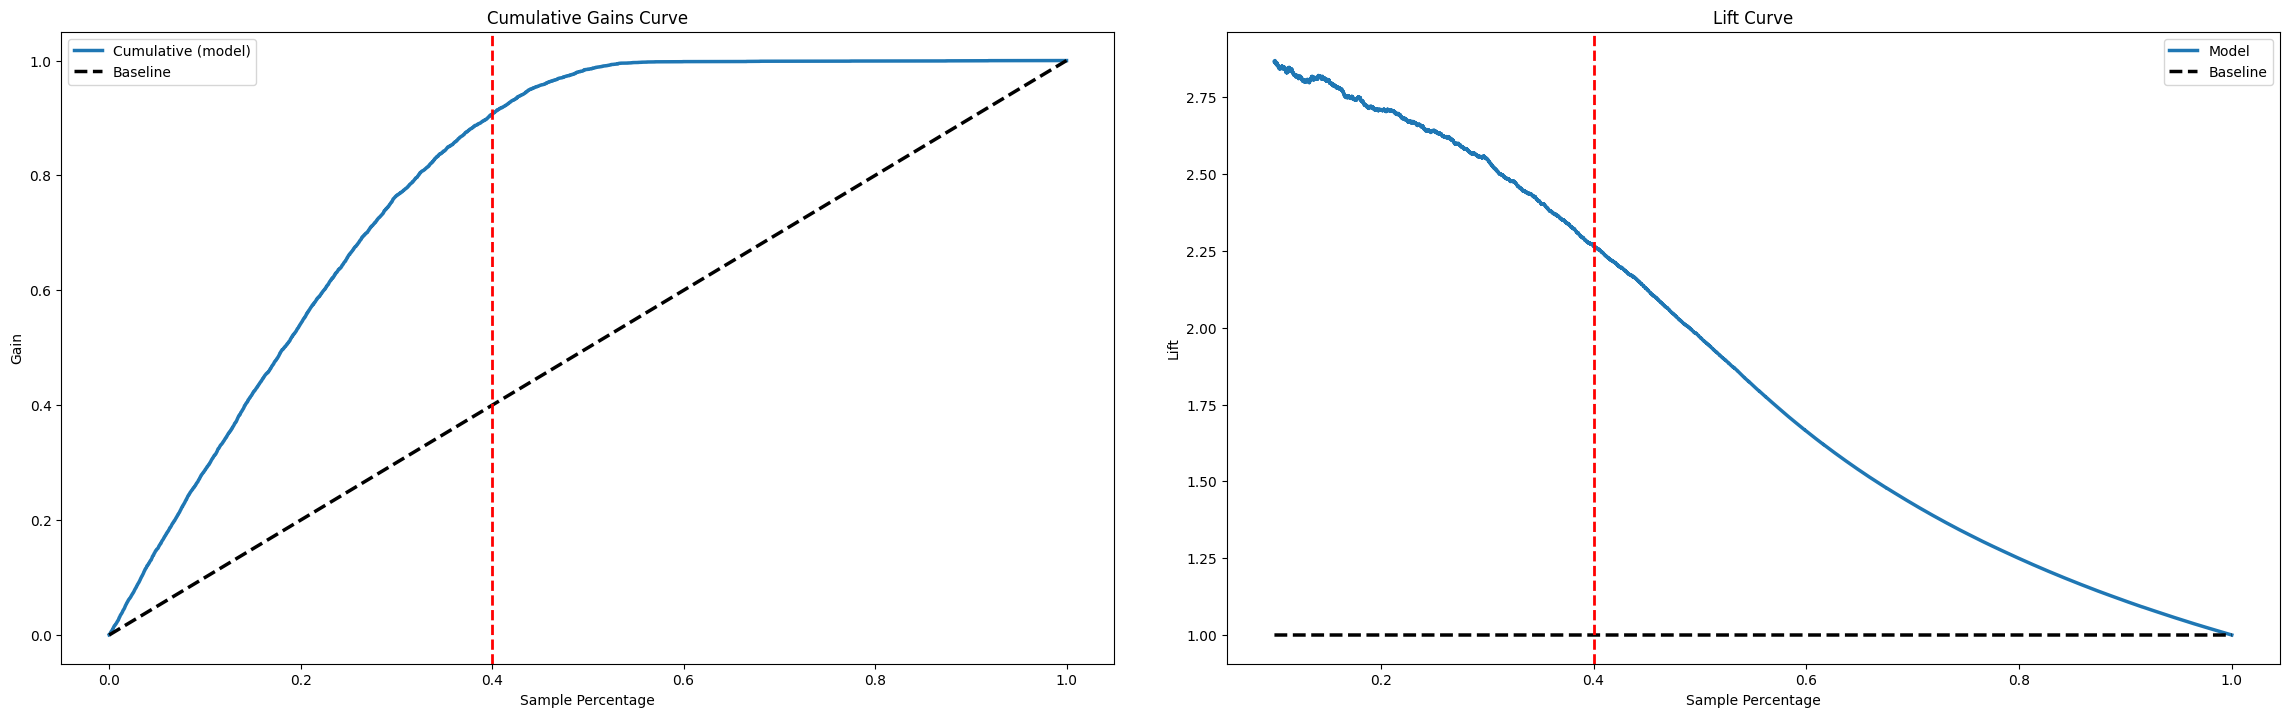

In [51]:
table_xgb = gain_lift_curve(yhat_xgb, y_val, axvline=0.4)

Figure 23. Cumulative gain and lift curve for the XGBoost model.

### 7.6.2. Precision and Recall XGBoost

In [79]:
metrics_xgb, new_table_xgb = precision_recall_at_k(table_xgb, 27440) #27440 corresponds to 40% of the customer base.

new_table_xgb

,0,1,target,correct,propensity_score,cumulative_propensity_score,cum_perc_base,lift,ranking,precision_at_k,recall_at_k
0,0.458806,0.541194,0,no,0.0,0.0,0.000021,0.000000,1,0.000000,0.0
1,0.481096,0.518904,0,no,0.0,0.0,0.000041,0.000000,2,0.000000,0.0
2,0.481096,0.518904,0,no,0.0,0.0,0.000062,0.000000,3,0.000000,0.0
3,0.481096,0.518904,0,no,0.0,0.0,0.000082,0.000000,4,0.000000,0.0
4,0.481096,0.518904,0,no,0.0,0.0,0.000103,0.000000,5,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
48587,0.999992,0.000008,0,yes,0.0,1.0,0.999918,1.000082,48588,0.122582,1.0
48588,0.999992,0.000008,0,yes,0.0,1.0,0.999938,1.000062,48589,0.122579,1.0
48589,0.999992,0.000008,0,yes,0.0,1.0,0.999959,1.000041,48590,0.122577,1.0
48590,0.999992,0.000008,0,yes,0.0,1.0,0.999979,1.000021,48591,0.122574,1.0


In [80]:
print(f"XGBoost - \nPrecision at 40% of base(k): {round( metrics_xgb[0] ,2)}\nRecall at 40% of base(k): {round( metrics_xgb[1] ,2) }")

XGBoost - 
Precision at 40% of base(k): 0.22
Recall at 40% of base(k): 1.0


### 7.6.3. Cross Validation XGBoost

In [81]:
xgb_cv = runCrossValidation ( xgb_model, X_train, x_val, pd.Series(y_train), pd.Series(y_val), 5, 5, top_k = 27440, verbose = False )
xgb_cv

,mean,std
precision_at_k,0.271777,0.000680
recall_at_k,0.939168,0.002344


## 7.7. Balanced Random Forest Model

/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.

/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning:

The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.



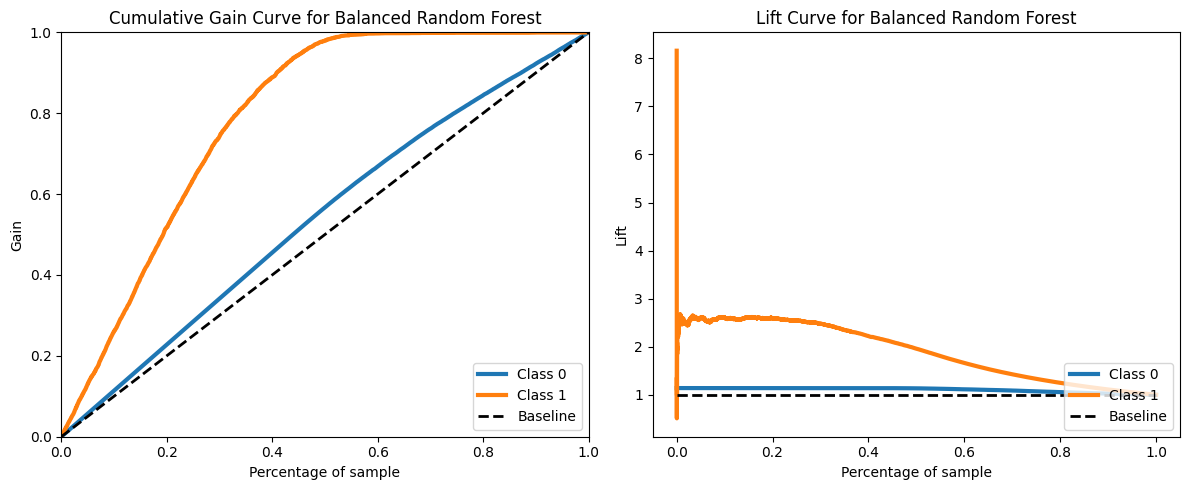

In [52]:
# model definition
brfm_model = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

# model training
brfm_model.fit(X_train, y_train )

# model prediction

yhat_brfm = brfm_model.predict_proba( x_val )

# Create a 1x2 grid
fig, axes = plt.subplots(1,2,figsize=(12,5))

#Cumulative gain Balanced Random Forest
skplt.metrics.plot_cumulative_gain( y_val, yhat_brfm, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve for Balanced Random Forest')
axes[0].grid(False)

#Lift curve Balanced Random Forest
skplt.metrics.plot_lift_curve( y_val, yhat_brfm, ax=axes[1])
axes[1].set_title('Lift Curve for Balanced Random Forest')
axes[1].grid(False)

plt.tight_layout()
plt.show()

Figure 24. Cumulative gain and lift curve for the balanced random forest model.

### 7.7.1 Model Evaluation Balanced Random Forest

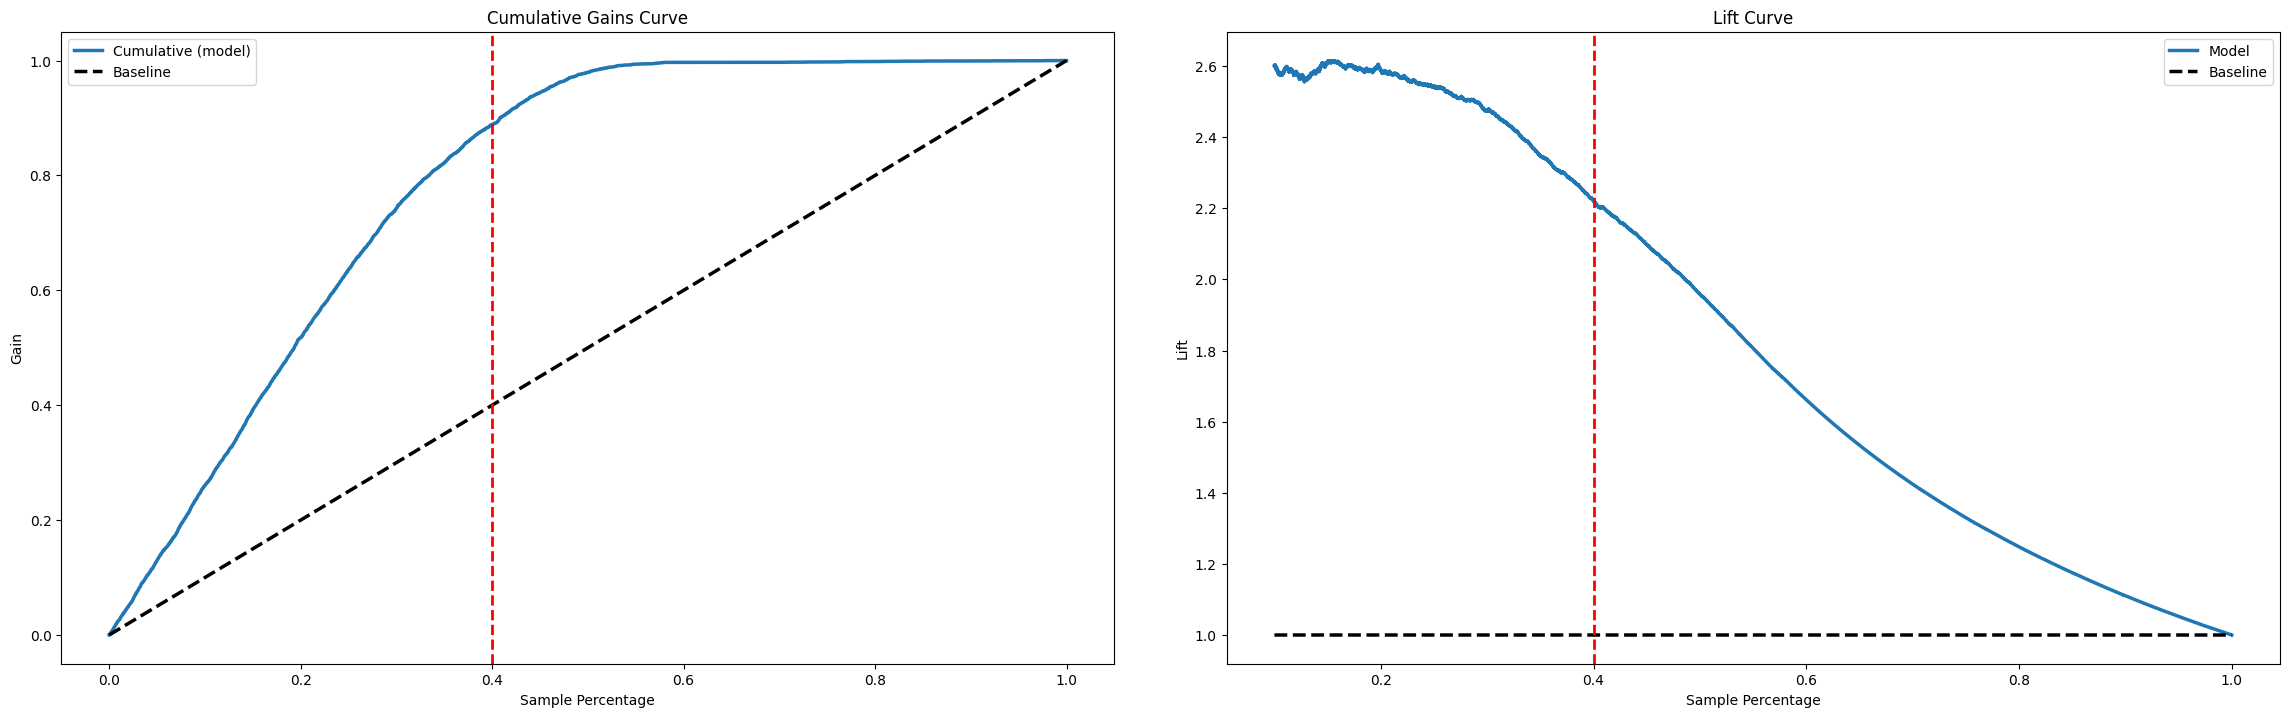

In [53]:
table_brfm = gain_lift_curve(yhat_brfm, y_val, axvline=0.4)

Figure 25. Cumulative gain and lift curve for the Balanced Random Forest model.

### 7.7.2. Precision and Recall Balanced Random Forest

In [84]:
metrics_brfm, new_table_brfm = precision_recall_at_k(table_brfm, 27440) #27440 corresponds to 40% of the customer base.

new_table_brfm

,0,1,target,correct,propensity_score,cumulative_propensity_score,cum_perc_base,lift,ranking,precision_at_k,recall_at_k
0,0.001667,0.998333,0,no,0.000000,0.000000,0.000021,0.000000,1,0.000000,0.000000
1,0.003750,0.996250,1,yes,0.000168,0.000168,0.000041,4.079248,2,0.500000,0.000168
2,0.003750,0.996250,0,no,0.000000,0.000168,0.000062,2.719499,3,0.333333,0.000168
3,0.003750,0.996250,0,no,0.000000,0.000168,0.000082,2.039624,4,0.250000,0.000168
4,0.020500,0.979500,0,no,0.000000,0.000168,0.000103,1.631699,5,0.200000,0.000168
...,...,...,...,...,...,...,...,...,...,...,...
48587,1.000000,0.000000,0,yes,0.000000,1.000000,0.999918,1.000082,48588,0.122582,1.000000
48588,1.000000,0.000000,0,yes,0.000000,1.000000,0.999938,1.000062,48589,0.122579,1.000000
48589,1.000000,0.000000,0,yes,0.000000,1.000000,0.999959,1.000041,48590,0.122577,1.000000
48590,1.000000,0.000000,0,yes,0.000000,1.000000,0.999979,1.000021,48591,0.122574,1.000000


In [85]:
print(f"Balanced Random Forest Model - \nPrecision at 40% of base(k): {round( metrics_brfm[0] ,2)}\nRecall at 40% of base(k): {round( metrics_brfm[1] ,2) }")

Balanced Random Forest Model - 
Precision at 40% of base(k): 0.22
Recall at 40% of base(k): 1.0


### 7.7.3. Cross Validation Balanced Random Forest

In [86]:
brfm_cv = runCrossValidation ( brfm_model, X_train, x_val, pd.Series(y_train), pd.Series(y_val), 5, 5, top_k = 27440, verbose = False )
brfm_cv

/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.

/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning:

The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.

/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original pa

,mean,std
precision_at_k,0.266977,0.000586
recall_at_k,0.922580,0.002013


## 7.8. Cross Validation of all models

In [87]:
cv_table = pd.concat([brfm_cv,xgb_cv,gb_cv,lgbm_cv,rf_cv,lr_cv,knn_cv], axis=1)
cv_table.columns = ['brfm_mean','brfm_sd','xgb_mean','xgb_sd',
                    'gb_mean','gb_sd','lgbm_mean','lgbm_sd',
                    'rf_mean','rf_sd','lr_mean','lr_sd','knn_mean','knn_sd']

cv_table = pd.DataFrame(cv_table)

cv_table

,brfm_mean,brfm_sd,xgb_mean,xgb_sd,gb_mean,gb_sd,lgbm_mean,lgbm_sd,rf_mean,rf_sd,lr_mean,lr_sd,knn_mean,knn_sd
precision_at_k,0.266977,0.000586,0.271777,0.000680,0.272306,0.000726,0.272315,0.000644,0.262529,0.000745,0.259394,0.001735,0.252754,0.001689
recall_at_k,0.922580,0.002013,0.939168,0.002344,0.940997,0.002519,0.941027,0.002227,0.907211,0.002566,0.896376,0.006004,0.873430,0.005837


# 8.0. Performance Metrics

In [88]:
# Table of the single performance at 40% of the base
prec_at_k_knn,  recall_at_k_knn = metrics_knn
prec_at_k_lr,   recall_at_k_lr = metrics_lr
prec_at_k_rf,   recall_at_k_rf = metrics_rf
prec_at_k_lgbm, recall_at_k_lgbm = metrics_lgbm
prec_at_k_gb,   recall_at_k_gb = metrics_gb
prec_at_k_xgb,  recall_at_k_xgb = metrics_xgb
prec_at_k_brfm, recall_at_k_brfm = metrics_brfm

dict_single_perf = {
    'Model:':['kNN','Logistic Regression','Random Forest','LGBM','Gradient Boost','XGBoost','Balanced Random Forest'],
    'Precision_at_k:':[prec_at_k_knn,prec_at_k_lr, prec_at_k_rf, prec_at_k_lgbm, prec_at_k_gb, prec_at_k_xgb, prec_at_k_brfm],
    'Recall_at_k:':[recall_at_k_knn, recall_at_k_lr, recall_at_k_rf, recall_at_k_lgbm, recall_at_k_gb, recall_at_k_xgb, recall_at_k_brfm]
    }

df_single_perf = pd.DataFrame(dict_single_perf)
df_single_perf.sort_values('Recall_at_k:', ascending = True)

,Model:,Precision_at_k:,Recall_at_k:
0,kNN,0.193914,0.893385
2,Random Forest,0.211625,0.974983
6,Balanced Random Forest,0.216217,0.996138
3,LGBM,0.216582,0.997817
1,Logistic Regression,0.216655,0.998153
4,Gradient Boost,0.216655,0.998153
5,XGBoost,0.216655,0.998153


In [55]:
# model ranked list
df_knn = table_knn
df_lr = table_lr
df_rf = table_rf
df_brfm = table_brfm
df_gb = table_gb
df_xgb = table_xgb
df_lgbm = table_lgbm

cols_selected = ['days_associated','health_annual_paid','age','region_code',
                 'vehicle_damage','policy_sales_channel', 'vehicle_prev_insured']

## 8.1. Cumulative Gain Curves

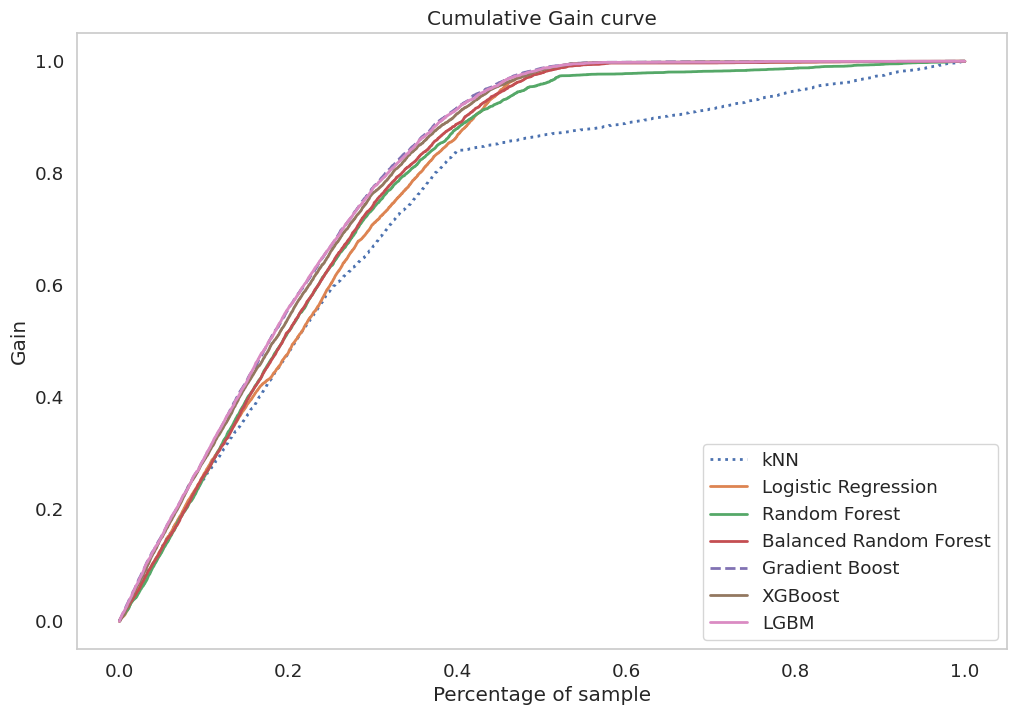

In [57]:
# Default matplotlib and seaborn config
matplotlib.rc_file_defaults()
sns.reset_orig
sns.set_theme(font_scale=1.2, style = "whitegrid")

# Plot graphs
fig, axes = plt.subplots(1,1,figsize = (12, 8))

# plot graphs
sns.lineplot(ax = axes, x = df_knn['cum_perc_base'], y=df_knn['cumulative_propensity_score'], label="kNN", linewidth = 2)
sns.lineplot(ax = axes, x = df_lr['cum_perc_base'], y=df_lr['cumulative_propensity_score'], label="Logistic Regression", linewidth = 2)
sns.lineplot(ax = axes, x = df_rf['cum_perc_base'], y=df_rf['cumulative_propensity_score'], label="Random Forest", linewidth = 2)
sns.lineplot(ax = axes, x = df_brfm['cum_perc_base'], y=df_brfm['cumulative_propensity_score'], label="Balanced Random Forest", linewidth = 2)
sns.lineplot(ax = axes, x = df_gb['cum_perc_base'], y=df_gb['cumulative_propensity_score'], label="Gradient Boost", linewidth = 2)
sns.lineplot(ax = axes, x = df_xgb['cum_perc_base'], y=df_xgb['cumulative_propensity_score'], label="XGBoost", linewidth = 2)
sns.lineplot(ax = axes, x = df_lgbm['cum_perc_base'], y=df_lgbm['cumulative_propensity_score'], label="LGBM", linewidth = 2)


axes.lines[0].set_linestyle(":")
axes.lines[4].set_linestyle("--")

axes.grid(False)

axes.legend()
axes.set_title("Cumulative Gain curve")
axes.set_xlabel("Percentage of sample")
axes.set_ylabel("Gain")

axes.plot;

Figure 26. Cumulative gain curves of all models.

## 8.2. Lift Curves

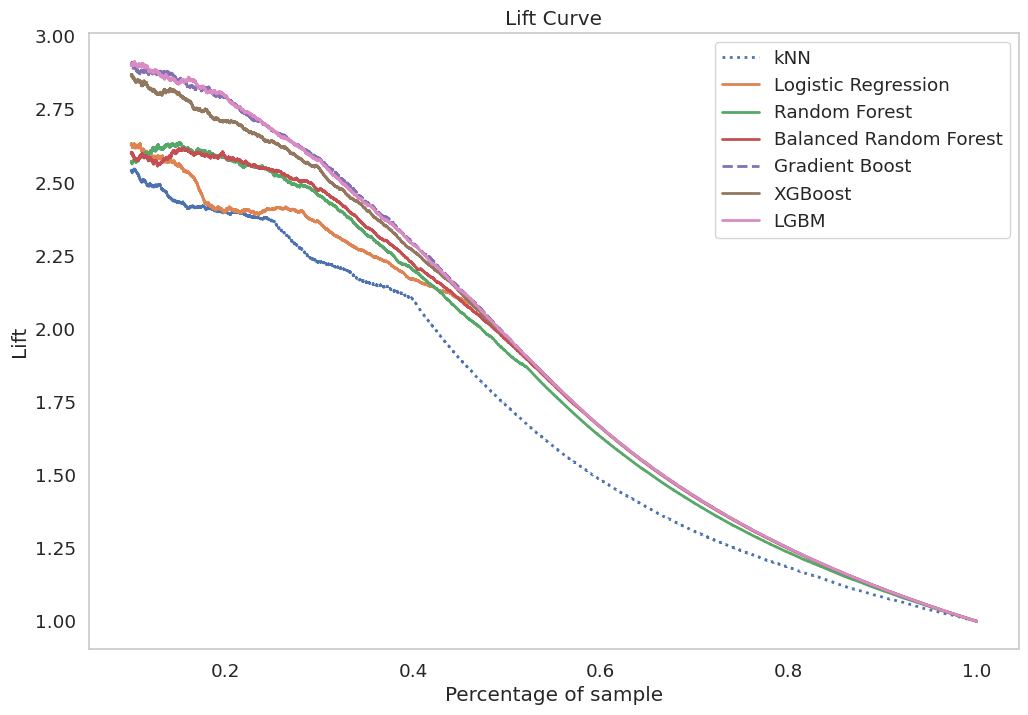

In [59]:
sns.set_theme(font_scale=1.2, style = "whitegrid")

df_knn_filtered  = df_knn.query('cum_perc_base >= 0.1')
df_lr_filtered   = df_lr.query('cum_perc_base >= 0.1')
df_rf_filtered   = df_rf.query('cum_perc_base >= 0.1')
df_brfm_filtered = df_brfm.query('cum_perc_base >= 0.1')
df_gb_filtered   = df_gb.query('cum_perc_base >= 0.1')
df_xgb_filtered  = df_xgb.query('cum_perc_base >= 0.1')
df_lgbm_filtered = df_lgbm.query('cum_perc_base >= 0.1')

# Plot graphs
fig, axes = plt.subplots(1,1,figsize = (12, 8))

# plot graphs
sns.lineplot(ax = axes, x = df_knn_filtered['cum_perc_base'], y=df_knn_filtered['lift'], label="kNN", linewidth = 2)
sns.lineplot(ax = axes, x = df_lr_filtered['cum_perc_base'], y=df_lr_filtered['lift'], label="Logistic Regression", linewidth = 2)
sns.lineplot(ax = axes, x = df_rf_filtered['cum_perc_base'], y=df_rf_filtered['lift'], label="Random Forest", linewidth = 2)
sns.lineplot(ax = axes, x = df_brfm_filtered['cum_perc_base'], y=df_brfm_filtered['lift'], label="Balanced Random Forest", linewidth = 2)
sns.lineplot(ax = axes, x = df_gb_filtered['cum_perc_base'], y=df_gb_filtered['lift'], label="Gradient Boost", linewidth = 2)
sns.lineplot(ax = axes, x = df_xgb_filtered['cum_perc_base'], y=df_xgb_filtered['lift'], label="XGBoost", linewidth = 2)
sns.lineplot(ax = axes, x = df_lgbm_filtered['cum_perc_base'], y=df_lgbm_filtered['lift'], label="LGBM", linewidth = 2)


axes.lines[0].set_linestyle(":")
axes.lines[4].set_linestyle("--")

axes.grid(False)

axes.legend()
axes.set_title("Lift Curve")
axes.set_xlabel("Percentage of sample")
axes.set_ylabel("Lift")

axes.plot;

Figure 27. Lift curve of all models.

In [92]:
df_precision = precision_recall_compiled(['df_knn','df_lr' ,'df_rf' ,'df_brfm','df_gb' ,'df_xgb' ,'df_lgbm'], y_val)[0]
df_precision


,Precision at,k-Nearest Neighbors,Logistic Regression,Random Forest,Balanced Random Forest,Gradient Boost,XGBoost,LGBM
0,10%,0.2883,0.3231,0.2867,0.2943,0.3495,0.3379,0.3525
1,20%,0.2853,0.2912,0.2868,0.2968,0.3346,0.3291,0.3341
2,30%,0.2737,0.2788,0.2783,0.2870,0.3124,0.3062,0.3113
3,40%,0.2566,0.2638,0.2621,0.2663,0.2797,0.2763,0.2795


In [93]:
df_recall = precision_recall_compiled(['df_knn','df_lr' ,'df_rf' ,'df_brfm','df_gb' ,'df_xgb' ,'df_lgbm'], y_val)[1]
df_recall

,Recall at,k-Nearest Neighbors,Logistic Regression,Random Forest,Balanced Random Forest,Gradient Boost,XGBoost,LGBM
0,10%,0.2352,0.2636,0.2339,0.2401,0.2851,0.2757,0.2876
1,20%,0.4656,0.4752,0.4679,0.4842,0.5460,0.5369,0.5452
2,30%,0.6697,0.6823,0.6812,0.7023,0.7646,0.7495,0.7619
3,40%,0.8373,0.8610,0.8553,0.8689,0.9127,0.9016,0.9120


## 8.3 Hyperparameter Fine Tuning

In [94]:
## results compiled in the following table

param = {
    'learning_rate':  [0.01, 0.05, 0.1, 0.15, 0.5],
    'num_leaves':  [10, 21, 31, 51, 100],
    'min_child_samples': [10, 20, 50, 80, 100],
    'colsample_bytree':[0.5, 1, 5, 10, 30]
    
    }

max_eval = 5

for i in range(max_eval):
    # random choice of dictionary values
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)

    # model definition
    lgbm_model = LGBMClassifier(learning_rate = hp['learning_rate'],
                                num_leaves = hp['num_leaves'],
                                min_child_samples = hp['min_child_samples'],
                                colsample_bytree = hp['colsample_bytree'],
                                bagging_fraction = 0.8,
                                feature_fraction = 0.8,
                                random_state = 0,
                                n_jobs = -1)
    
    display(runCrossValidation(lgbm_model, X_train, x_val, pd.Series(y_train), pd.Series(y_val), n_splits = 10, n_repeats = 2, top_k = 27440))

{'learning_rate': 0.15, 'num_leaves': 10, 'min_child_samples': 20, 'colsample_bytree': 10}
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=10 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=10 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 31762, number of negative: 227391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 259153, number of used features: 6
[Ligh

,mean,std
precision_at_k,0.272404,0.000693
recall_at_k,0.941334,0.002401


{'learning_rate': 0.15, 'num_leaves': 51, 'min_child_samples': 100, 'colsample_bytree': 5}
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 31762, number of negative: 227391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 259153, number of used features: 6
[LightG

,mean,std
precision_at_k,0.272122,0.000682
recall_at_k,0.940362,0.002348


{'learning_rate': 0.01, 'num_leaves': 100, 'min_child_samples': 50, 'colsample_bytree': 0.5}
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 31762, number of negative: 227391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 259153, number of used features: 6
[

,mean,std
precision_at_k,0.272359,0.000779
recall_at_k,0.941178,0.002700


{'learning_rate': 0.5, 'num_leaves': 10, 'min_child_samples': 100, 'colsample_bytree': 0.5}
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 31762, number of negative: 227391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 259153, number of used features: 6
[L

,mean,std
precision_at_k,0.272032,0.000708
recall_at_k,0.940050,0.002445


{'learning_rate': 0.01, 'num_leaves': 21, 'min_child_samples': 20, 'colsample_bytree': 30}
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=30 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=30 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 31762, number of negative: 227391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 259153, number of used features: 6
[Ligh

,mean,std
precision_at_k,0.272157,0.000811
recall_at_k,0.940483,0.002810


In [95]:
final_results = { 'model':['1','2','3','4','5'],
    'precision_at_k':['0.281038 +/- 0.000633',
                     '0.279497 +/- 0.001204',
                     '0.278593 +/- 0.005254',
                     '0.281063 +/- 0.000639',
                     '0.280583 +/- 0.000706'],
 
    'recall_at_k': ['0.917205 +/- 0.002066',
                	'0.912177 +/- 0.003926',
                	'0.909227 +/- 0.017153',
                	'0.917286 +/- 0.002085',
                	'0.915721 +/- 0.002301'],


    'parameters':[  "'learning_rate': 0.1, 'num_leaves': 21, 'min_child_samples': 10, 'colsample_bytree': 10",
                    "'learning_rate': 0.5, 'num_leaves': 51, 'min_child_samples': 50, 'colsample_bytree': 0.5",
                    "'learning_rate': 0.5, 'num_leaves': 21, 'min_child_samples': 10, 'colsample_bytree': 1",
                    "'learning_rate': 0.15, 'num_leaves': 21, 'min_child_samples': 80, 'colsample_bytree': 0.5",
                    "'learning_rate': 0.01, 'num_leaves': 10, 'min_child_samples': 80, 'colsample_bytree': 1"]

}

print(tabulate(final_results, headers=['model','precision@k','recall@k', 'hyperparameters'], tablefmt="fancy_grid"))

╒═════════╤═══════════════════════╤═══════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════╕
│   model │ precision@k           │ recall@k              │ hyperparameters                                                                           │
╞═════════╪═══════════════════════╪═══════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════╡
│       1 │ 0.281038 +/- 0.000633 │ 0.917205 +/- 0.002066 │ 'learning_rate': 0.1, 'num_leaves': 21, 'min_child_samples': 10, 'colsample_bytree': 10   │
├─────────┼───────────────────────┼───────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│       2 │ 0.279497 +/- 0.001204 │ 0.912177 +/- 0.003926 │ 'learning_rate': 0.5, 'num_leaves': 51, 'min_child_samples': 50, 'colsample_bytree': 0.5  │
├─────────┼───────────────────────┼───────────────────────┼─────────────────────────────

### 8.3.1. Model Training and Ranked List Export

**Train tuned model, plot gain, and lift curve, and present metrics for precision and recall at k for the best model (number 4).**

In [60]:
# Model definition

lgbm_model = LGBMClassifier(learning_rate = 0.15,
                            num_leaves = 21,
                            min_child_samples = 80,
                            colsample_bytree = 0.5,
                            bagging_fraction = 0.8,
                            feature_fraction = 0.8,
                            random_state = 0,
                            n_jobs = -1)

# Model training
lgbm_model.fit(X_train, y_train)

# Model prediction
yhat_lgbm = lgbm_model.predict_proba( x_val )

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 33747, number of negative: 241603
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 275350, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122560 -> initscore=-1.968404
[LightGBM] [In

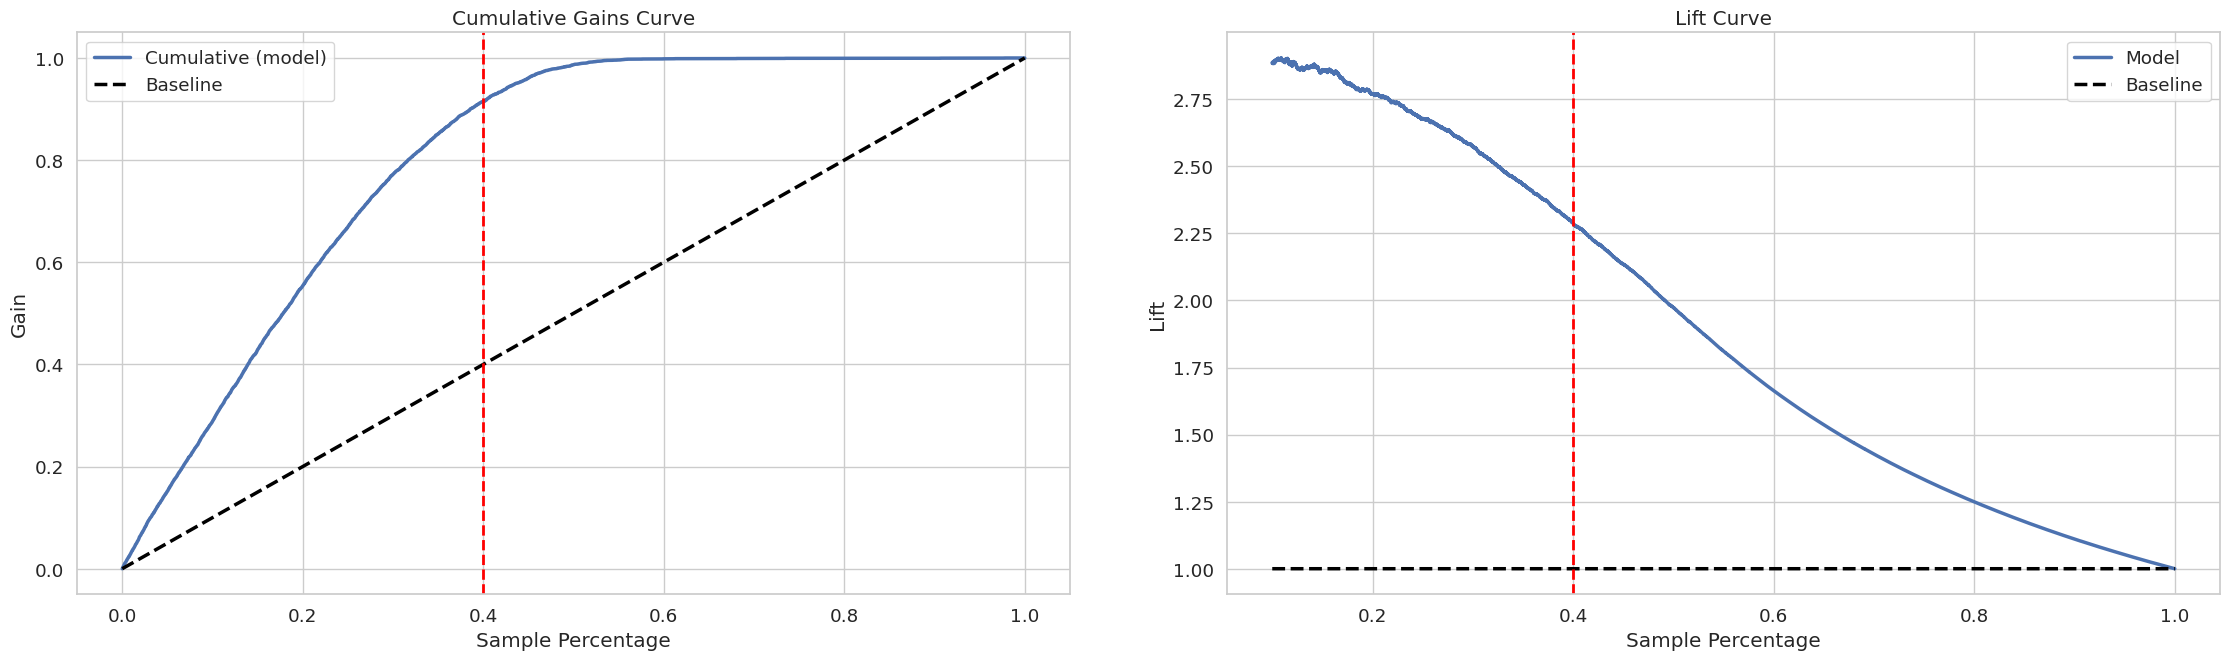

In [61]:
table_tuned_lgmb = gain_lift_curve(yhat_lgbm, y_val, axvline=0.4 )
metrics_lgbm, new_table_lgbm = precision_recall_at_k(table_tuned_lgmb, 27440) #27440 corresponds to 40% of the customers

In [62]:
new_table_lgbm

,0,1,target,correct,propensity_score,cumulative_propensity_score,cum_perc_base,lift,ranking,precision_at_k,recall_at_k
0,0.555469,0.444531,0,yes,0.000000,0.000000,0.000021,0.000000,1,0.000000,0.000000
1,0.555469,0.444531,0,yes,0.000000,0.000000,0.000041,0.000000,2,0.000000,0.000000
2,0.561170,0.438830,0,yes,0.000000,0.000000,0.000062,0.000000,3,0.000000,0.000000
3,0.561170,0.438830,1,no,0.000168,0.000168,0.000082,2.039624,4,0.250000,0.000168
4,0.561170,0.438830,1,no,0.000168,0.000336,0.000103,3.263398,5,0.400000,0.000336
...,...,...,...,...,...,...,...,...,...,...,...
48587,0.999983,0.000017,0,yes,0.000000,1.000000,0.999918,1.000082,48588,0.122582,1.000000
48588,0.999983,0.000017,0,yes,0.000000,1.000000,0.999938,1.000062,48589,0.122579,1.000000
48589,0.999983,0.000017,0,yes,0.000000,1.000000,0.999959,1.000041,48590,0.122577,1.000000
48590,0.999984,0.000016,0,yes,0.000000,1.000000,0.999979,1.000021,48591,0.122574,1.000000


In [99]:
metrics_lgbm

(0.21665451895043733, 0.998153122901276)

### 8.3.4. Model Testing

Here, the LGBM model will be trained using the compiled  training and validation data set, and tested using the test data set. This approach aims to check the generalization power of the model.

In [63]:
# Concatenate train and validation datasets

x_train = pd.concat([X_train, x_val ])
y_train = pd.concat([pd.Series(y_train), pd.Series(y_val) ])

In [64]:
# Vehicle damage number
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [65]:
mms_age_test = pp.MinMaxScaler()
mms_vintage_test = pp.MinMaxScaler()

# Age - MinMaxScaler
df_test['age'] = mms_age_test.fit_transform(df_test[['age']].values)
pickle.dump(mms_age_test, open('../src/features/age_scaler_test.pkl', 'wb') )

# Vintage - MinMaxScaler
df_test['vintage'] = mms_vintage_test.fit_transform(df_test[['vintage']].values )
pickle.dump(mms_vintage_test, open('../src/features/vintage_scaler_test.pkl','wb') )

In [66]:
%%time
# Gender - OneHotEncoding/ Target encoding
target_encode_gender_test = df_test.groupby('gender')['response'].mean()
df_test.loc[:, 'gender'] = df_test['gender'].map(target_encode_gender_test )
pickle.dump( target_encode_gender_test, open('../src/features/target_encode_gender_scaler_test.pkl','wb'))
                                        
# Region_code - Target encoding/ Frequency encoding
target_encode_region_code_test = df_test.groupby('region_code')['response'].mean()
df_test.loc[:, 'region_code'] = df_test['region_code'].map(target_encode_region_code_test )
pickle.dump( target_encode_region_code_test, open('../src/features/target_encode_region_code_scaler_test.pkl','wb'))
                                        
# vehicle_age - OneHotEncoding/ Frequency Encoding
df_test = pd.get_dummies(df_test, prefix='vehicle_age', columns=['vehicle_age'] )
                                        
# policy_sales_channel - target encoding / Frequency encoding
fe_policy_sales_channel_test = df_test.groupby( 'policy_sales_channel' ).size()/len(df_test)
df_test.loc[:,'policy_sales_channel'] = df_test['policy_sales_channel'].map(fe_policy_sales_channel_test )
pickle.dump(fe_policy_sales_channel_test, open('../src/features/fe_policy_sales_channel_scaler_test.pkl','wb' ))

CPU times: user 44.6 ms, sys: 8.05 ms, total: 52.6 ms
Wall time: 50.6 ms


In [67]:
df_test = df_test[['previously_insured', 'gender', 'age', 'driving_license', 'region_code',
       'vehicle_damage']]
df_test['gender'] = df_test['gender'].astype(float)

In [68]:
# Model definition

lgbm_model = LGBMClassifier(learning_rate = 0.15,
                            num_leaves = 21,
                            min_child_samples = 80,
                            colsample_bytree = 0.5,
                            bagging_fraction = 0.8,
                            feature_fraction = 0.8,
                            random_state = 0,
                            n_jobs = -1)

# Model training
lgbm_model.fit(x_train, y_train)

# Model prediction
yhat_lgbm_final = lgbm_model.predict_proba( df_test )

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 39703, number of negative: 284239
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 323942, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122562 -> initscore=-1.968389
[LightGBM] [In

### 8.3.5. Cumulative Gain and Lift curves

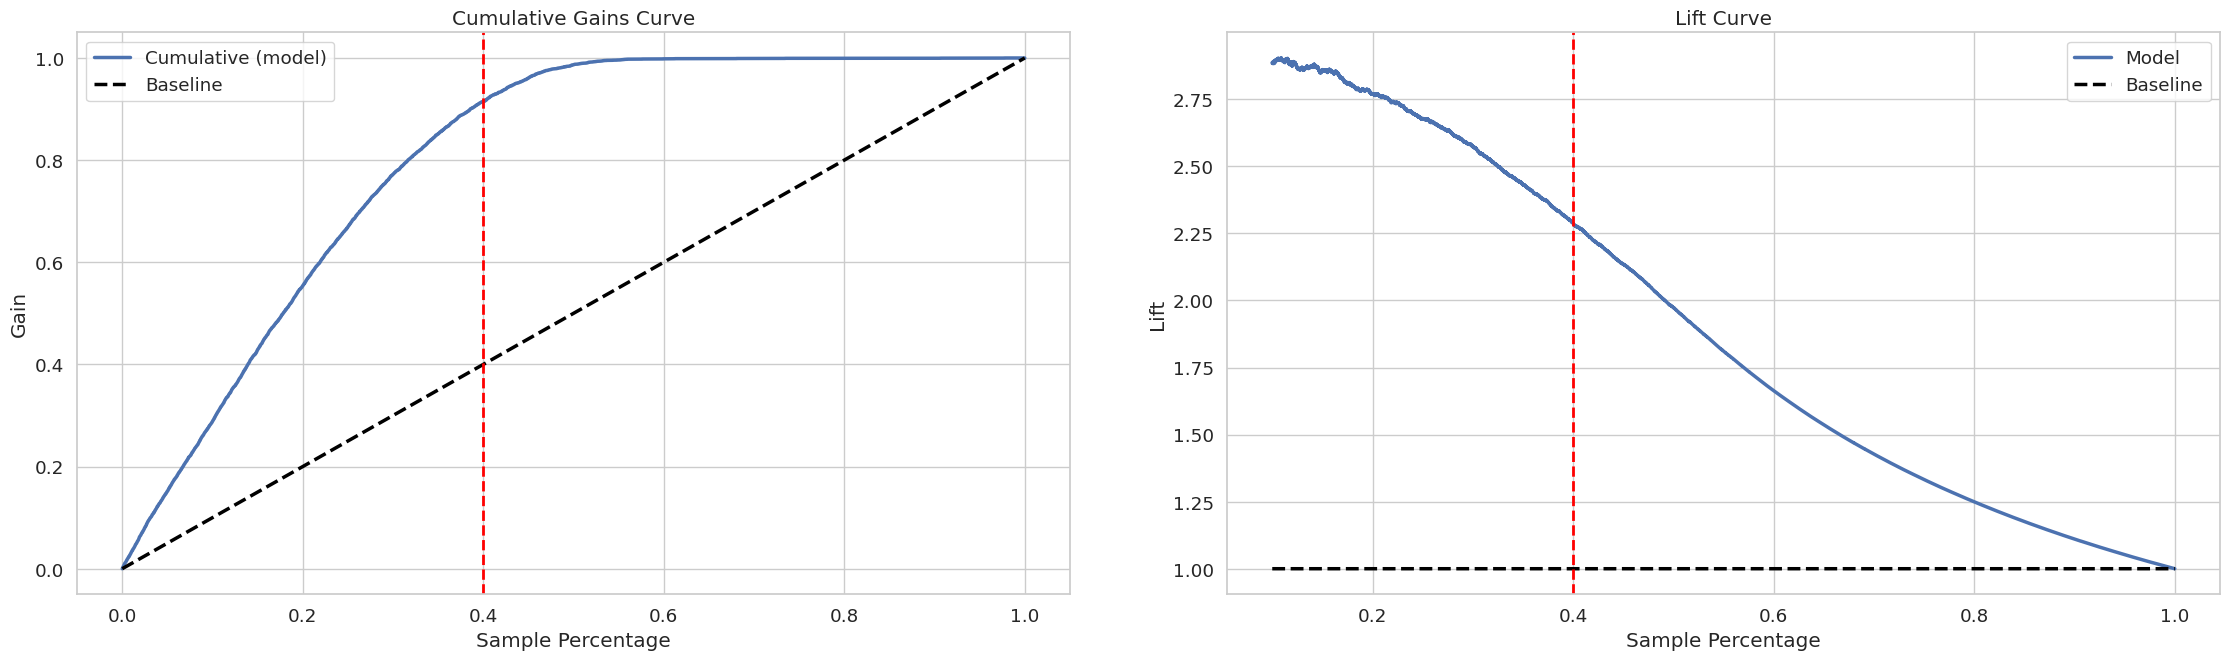

In [69]:
table_tuned_lgmb = gain_lift_curve(yhat_lgbm, y_val, axvline=0.4 )
metrics_lgbm, new_table_lgbm = precision_recall_at_k(table_tuned_lgmb, 27440) #27440 corresponds to 40% of the customers

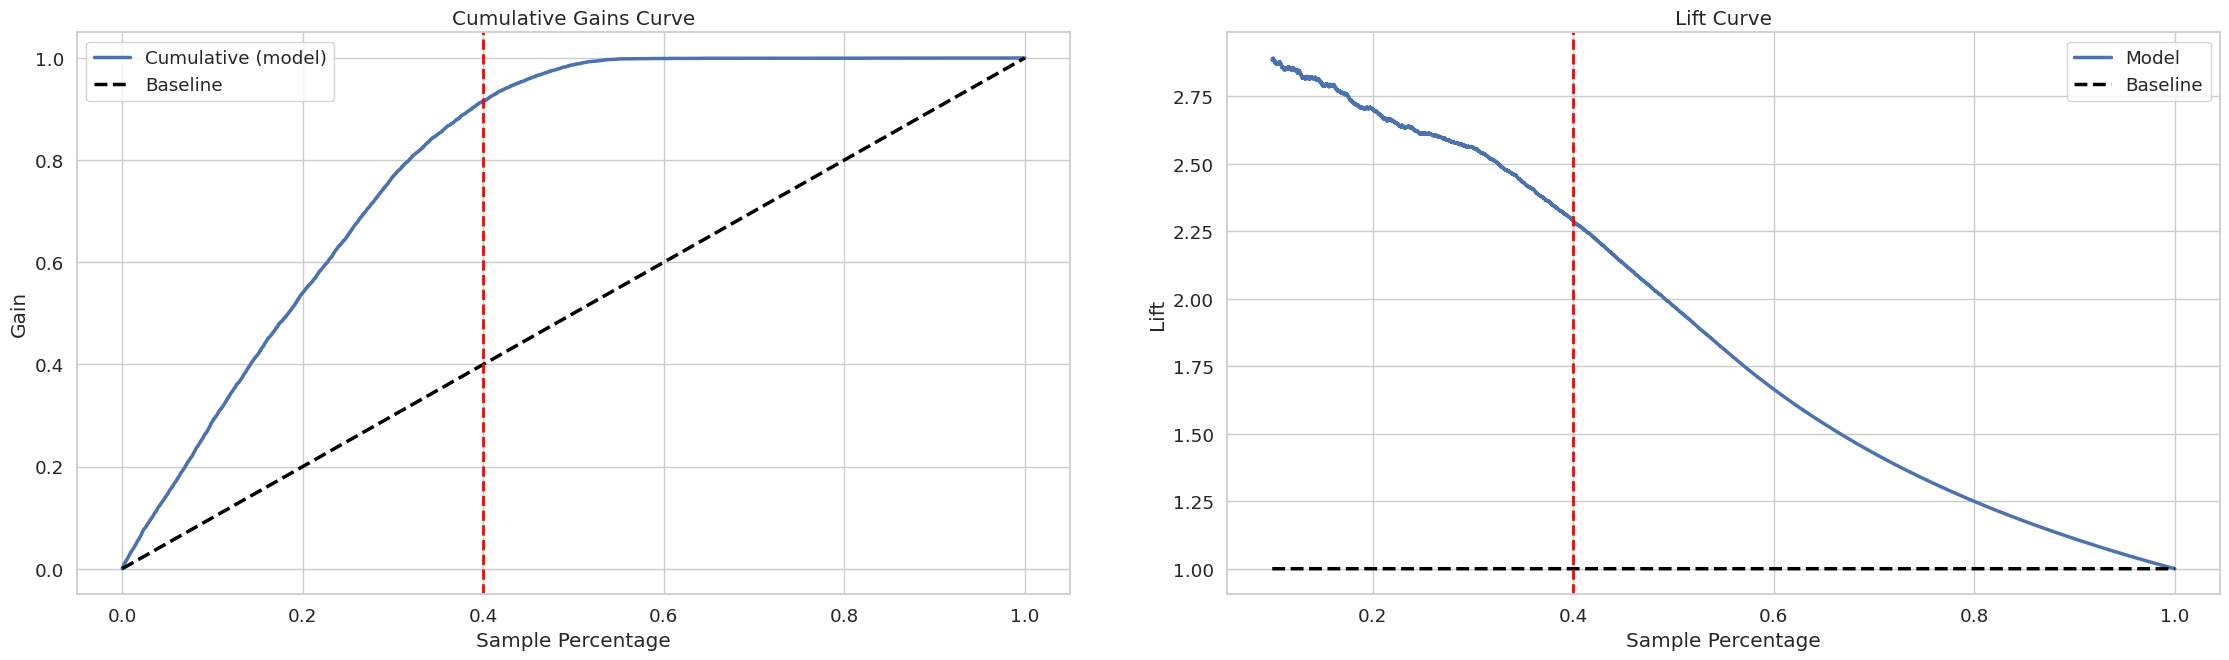

In [70]:
lgbm_test_final = gain_lift_curve(yhat_lgbm_final, y_test, size = (24,8), axvline=0.4)
metrics_lgbm_test, new_table_lgbm_test = precision_recall_at_k(lgbm_test_final, 27440) #27440 corresponds to 40% of the customers


In [108]:
new_table_lgbm_test

,0,1,target,correct,propensity_score,cumulative_propensity_score,cum_perc_base,lift,ranking,precision_at_k,recall_at_k
0,0.551102,0.448898,1,no,0.000143,0.000143,0.000017,8.158556,1,1.000000,0.000143
1,0.551102,0.448898,0,yes,0.000000,0.000143,0.000035,4.079278,2,0.500000,0.000143
2,0.551102,0.448898,0,yes,0.000000,0.000143,0.000052,2.719519,3,0.333333,0.000143
3,0.551102,0.448898,0,yes,0.000000,0.000143,0.000070,2.039639,4,0.250000,0.000143
4,0.554420,0.445580,0,yes,0.000000,0.000143,0.000087,1.631711,5,0.200000,0.000143
...,...,...,...,...,...,...,...,...,...,...,...
57162,0.999981,0.000019,0,yes,0.000000,1.000000,0.999930,1.000070,57163,0.122579,1.000000
57163,0.999981,0.000019,0,yes,0.000000,1.000000,0.999948,1.000052,57164,0.122577,1.000000
57164,0.999982,0.000018,0,yes,0.000000,1.000000,0.999965,1.000035,57165,0.122575,1.000000
57165,0.999984,0.000016,0,yes,0.000000,1.000000,0.999983,1.000017,57166,0.122573,1.000000


In [109]:
metrics_lgbm_test

(0.25065597667638484, 0.9815898387326959)

### 8.3.6. Precision and Recall at k Assessment

In [110]:
# Create a dictionary for each metric
dict_precision = {'Precision':['10%','20%','30%','40%']}
dict_recall = {'Recall':['10%','20%','30%','40%']}

# Metrics using the compiled train and validation dataset
metrics10_train, _ = precision_recall_at_k(table_tuned_lgmb,table_tuned_lgmb.shape[0]*10//100)
metrics20_train, _ = precision_recall_at_k(table_tuned_lgmb,table_tuned_lgmb.shape[0]*20//100)
metrics30_train, _ = precision_recall_at_k(table_tuned_lgmb,table_tuned_lgmb.shape[0]*30//100)
metrics40_train, _ = precision_recall_at_k(table_tuned_lgmb,table_tuned_lgmb.shape[0]*40//100)

# Metrics using the test dataset
metrics10_test, _ = precision_recall_at_k(lgbm_test_final,lgbm_test_final.shape[0]*10//100)
metrics20_test, _ = precision_recall_at_k(lgbm_test_final,lgbm_test_final.shape[0]*20//100)
metrics30_test, _ = precision_recall_at_k(lgbm_test_final,lgbm_test_final.shape[0]*30//100)
metrics40_test, _ = precision_recall_at_k(lgbm_test_final,lgbm_test_final.shape[0]*40//100)

# Create dictionaries to compare metrics
## train+validation
dict_precision['lgbm( train )'] = [round(metrics10_train[0], 3),
                                   round(metrics20_train[0], 3),
                                   round(metrics30_train[0], 3),
                                   round(metrics40_train[0], 3)]

#test
dict_precision['lgbm( test )'] = [round(metrics10_test[0], 3),
                                  round(metrics20_test[0], 3),
                                  round(metrics30_test[0], 3),
                                  round(metrics40_test[0], 3)]

## train+validation
dict_recall['lgbm( train )'] = [round(metrics10_train[1], 3),
                                round(metrics20_train[1], 3),
                                round(metrics30_train[1], 3),
                                round(metrics40_train[1], 3)]

#test
dict_recall['lgbm( test )'] = [round(metrics10_test[1], 3),
                               round(metrics20_test[1], 3),
                               round(metrics30_test[1], 3),
                               round(metrics40_test[1], 3)]

# Converting dictionary to data frame
df_precision = pd.DataFrame(dict_precision)
df_recall = pd.DataFrame(dict_recall)

In [111]:
print(tabulate(df_precision, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════════╤═════════════════╤════════════════╕
│    │ Precision   │   lgbm( train ) │   lgbm( test ) │
╞════╪═════════════╪═════════════════╪════════════════╡
│  0 │ 10%         │           0.355 │          0.346 │
├────┼─────────────┼─────────────────┼────────────────┤
│  1 │ 20%         │           0.332 │          0.329 │
├────┼─────────────┼─────────────────┼────────────────┤
│  2 │ 30%         │           0.309 │          0.311 │
├────┼─────────────┼─────────────────┼────────────────┤
│  3 │ 40%         │           0.279 │          0.281 │
╘════╧═════════════╧═════════════════╧════════════════╛


In [112]:
print(tabulate(df_recall, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════╤═════════════════╤════════════════╕
│    │ Recall   │   lgbm( train ) │   lgbm( test ) │
╞════╪══════════╪═════════════════╪════════════════╡
│  0 │ 10%      │           0.289 │          0.283 │
├────┼──────────┼─────────────────┼────────────────┤
│  1 │ 20%      │           0.542 │          0.537 │
├────┼──────────┼─────────────────┼────────────────┤
│  2 │ 30%      │           0.757 │          0.761 │
├────┼──────────┼─────────────────┼────────────────┤
│  3 │ 40%      │           0.912 │          0.916 │
╘════╧══════════╧═════════════════╧════════════════╛


# 9.0 Deploy model to Production

## 9.1. Health Insurance Class

In [71]:
# Save model
pickle.dump( lgbm_model, open('/media/thiago/thiago_1tb/thiago/2022/data_science/seja_um_data_scientist/CDS/data_formation/pa004/health_insurance_cross_sell/models/lgbm_model_final.pkl','wb' ))

In [72]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__(self):
        self.home_path = '/media/thiago/thiago_1tb/thiago/2022/data_science/seja_um_data_scientist/CDS/data_formation/pa004/health_insurance_cross_sell/'
        self.annual_premium_scaler = pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl','rb'))
        self.age_scaler = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl','rb'))
        self.vintage_scaler = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl','rb'))
        self.annual_premium_scaler = pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl','rb'))
        self.target_encode_gender_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl','rb'))
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl','rb'))
        self.fe_policy_sales_channel_scaler = pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl','rb'))
        
    def data_cleaning( self, df1 ):
        #1.0. Rename columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
        
        # Rename
        df1.columns = cols_new
        
        return df1
    
    def feature_engineering( self, df2 ):
        #2.0 Feature engineering
        
        # Vehicle damage number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )
        
        # Vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' if x == '1-2 Year' else 'below_1_year')
        
        return df2
    
    def data_preparation( self, df5 ):
        # Annual premium - StandardScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)
        
        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )
        
        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )
        
        # Gender - One Hot Encoding/ Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender )
        
        # Region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code )
        
        # Vehicle age - One Hot Encoding/ Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )
        
        # Policy sales channes - Target Encoding/ Frequency Encoding
        df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel )
        
        # Feature selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage','previously_insured',                          'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
                
        # join predicted to original data
        original_data['prediction'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient = 'records', date_format='iso' )

## 9.2. API Handler

In [75]:
import pickle
import pandas as pd
import requests
import json
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# Loading model
path = '/media/thiago/thiago_1tb/thiago/2022/data_science/seja_um_data_scientist/CDS/data_formation/pa004/health_insurance_cross_sell/'
model = pickle.load( open( path + 'src/models/lgbm_model_final.pkl','rb' ) )

# Initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance', methods = ['POST'] )

def health_insurance_predict():
    
    test_json = request.get_json()
    
    if test_json: # are there data?
        if isinstance( test_json, dict ): # single example
            test_raw = pd.DataFrame( test_json, index = [0] )
            
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Health Insurance Class
        pipeline = HealthInsurance()
        
        # Data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # Feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # Data preparation
        df3 = pipeline.data_preparationt( df2 )
        
        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )
            


 * Serving Flask app '__main__'
 * Debug mode: on


/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.18:5000
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "/home/thiago/.pyenv/versions/3.10.4/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/thiago/.pyenv/versions/3.10.4/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <modu

SystemExit: 1

/home/thiago/.pyenv/versions/3.10.4/envs/pa004/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



## 9.4. API Tester

In [76]:
import requests
import json


In [77]:
# Convert data frame do json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [78]:
# API Call
# url = 'http://0.0.0.0:5000/healthinsurance'
url = 'https://health-insurance-deploy.onrender.com/healthinsurance'
header = { 'Content-type':'application/json' }
data = data
r = requests.post( url, data = data, headers=header )
print('Status code: {}'.format( r.status_code ))

Status code: 500
